In [1]:
import numpy as np
from decifer.utility import (
    extract_numeric_property,
    pxrd_from_cif
)
import pickle
import os

import matplotlib.pyplot as plt

from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.patches import FancyArrowPatch, PathPatch
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties

from ase.visualize.plot import plot_atoms

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure as PMGStructure
from pymatgen.io.ase import AseAtomsAdaptor

def plot_unit_cell_with_boundaries(structure, ax=None, tol=1e-5, radii=0.8, rotation=('45x, -15y, 90z'), offset=(0, 0, 0)):
    """
    Plots the unit cell along with image atoms from neighboring cells (in the positive x, y, and z directions)
    that are exactly on the unit cell boundary onto a provided axis.
    
    Parameters:
        structure (pymatgen.core.structure.Structure): The input structure.
        ax (matplotlib.axes.Axes): Axis to plot on. If None, a new axis is created.
        tol (float): Tolerance for determining if an atom's fractional coordinate is on the boundary.
        radii (float): Radii for visualizing atoms.
        rotation (tuple or str): Rotation settings for the plot_atoms function.
        
    Returns:
        (ax, discrete_structure): The matplotlib axis containing the plotted structure 
            and the discrete pymatgen Structure constructed.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Define translation vectors for the original cell and its neighboring cells in the positive directions.
    translation_vectors = [
        [0, 0, 0],  # Original cell
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1]
    ]
    
    all_species = []
    all_coords = []
    
    # Loop over each translation vector.
    for tv in translation_vectors:
        tv_cart = structure.lattice.get_cartesian_coords(tv)
        for site in structure:
            if tv == [0, 0, 0]:
                # For the original cell, include all atoms.
                all_species.append(site.species_string)
                all_coords.append(site.coords)
            else:
                # For neighboring cells, include only atoms on the cell boundary
                # (i.e. the atom's fractional coordinate is nearly zero in each shifted direction).
                if all(site.frac_coords[i] < tol for i, shift in enumerate(tv) if shift == 1):
                    all_species.append(site.species_string)
                    all_coords.append(site.coords + tv_cart)
    
    all_coords = np.array(all_coords)
    
    # Build a bounding box that encloses the collected atoms.
    min_coords = all_coords.min(axis=0)
    max_coords = all_coords.max(axis=0)
    lattice_vectors = np.diag(max_coords - min_coords)
    
    discrete_structure = PMGStructure(
        lattice=lattice_vectors,
        species=all_species,
        coords=all_coords,
        coords_are_cartesian=True
    )
    
    # Convert the discrete pymatgen structure to an ASE Atoms object and remove periodic boundaries.
    ase_atoms = AseAtomsAdaptor.get_atoms(discrete_structure)
    ase_atoms.set_pbc([False, False, False])
    
    # Plot onto the provided axis.
    plot_atoms(ase_atoms, ax, radii=radii, show_unit_cell=True, rotation=rotation, offset=offset)
    
    return ax, discrete_structure

In [2]:
def ablation_fig(
    results, uresults, param_keys, savepath=None, dpi=100, figscale=1, figlen=10,
    wspace_outer=0.2, wspace_left=0.1, show_AB=True, show_u=False,
    fig_height_factor=2.25, cell_min=None, cell_max=None,
    bbox_left=(0.75, 1.2), bbox_right=(0.75, 1.2), ncol_left=1, ncol_right=1,
    AB_x=6.0, cell_tags=["a", "b", "c"], title_left=None, title_left_pad=0.0,
    show_mid=True, plot_ubest=False, show_mean=True, show_best=True,
    AB_symbols=["A", "B"]
):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import matplotlib.patheffects as path_effects
    import numpy as np

    # Helper functions
    def extract_pxrd(data, p_key, ex_key):
        exp = data[p_key][ex_key]["best_experiment"]
        ref = exp["pxrd_ref"]
        gen_clean = exp["pxrd_gen_clean"]
        return ref["q"], ref["iq"], gen_clean["q_disc"][0], gen_clean["iq_disc"][0]

    def compute_best_lengths(data, p_key, p_val_keys):
        best_cifs = [data[p_key][key]["best_experiment"]["generated_cif"] for key in p_val_keys]
        return [np.mean([extract_numeric_property(cif, f"_cell_length_{dim}") for dim in cell_tags])
                for cif in best_cifs]

    def compute_stats(data_section, p_key, p_val_keys, handle_empty=False):
        all_lengths, all_angles = [], []
        for key in p_val_keys:
            experiments = data_section[p_key][key]["experiments"]
            lengths = [extract_numeric_property(exp["generated_cif"], f"_cell_length_{dim}") for exp in experiments for dim in cell_tags]
            angles = [extract_numeric_property(exp["generated_cif"], f"_cell_angle_{dim}") for exp in experiments for dim in ["alpha", "beta", "gamma"]]
            all_lengths.append(lengths)
            all_angles.append(angles)

        mean_func = lambda l: np.mean(l) if l else np.mean(np.concatenate(all_lengths))
        std_func = lambda l: np.std(l) if l else 0.0

        mean_lengths = np.array([mean_func(l) for l in all_lengths])
        std_lengths = np.array([std_func(l) for l in all_lengths])
        mean_angles = np.array([mean_func(l) for l in all_angles])
        std_angles = np.array([std_func(l) for l in all_angles])

        return mean_lengths, std_lengths, mean_angles, std_angles

    def compute_match_stats(data_section, p_key, p_val_keys, handle_empty=False):
        match_rates = []
        for key in p_val_keys:
            experiments = data_section[p_key][key]["experiments"]
            rates = [exp["structure_match"] for exp in experiments]
            match_rates.append(rates)

        mean_func = lambda r: np.mean(r) if r else 0.0
        std_func = lambda r: np.std(r) if r else 0.0

        mean_rates = np.array([mean_func(r) for r in match_rates])
        std_rates = np.array([std_func(r) for r in match_rates])

        return mean_rates, std_rates

    # Plot settings
    colors = {
        "exp": "k",
        "pred": "#DC143C",
        "pred_u": "#008080",
        "ref": "k"
    }
    pred_marker_size = 2
    peak_scaling = 0.8
    n_params = len(param_keys)

    # Setup figure
    fig = plt.figure(figsize=(figlen * figscale, (fig_height_factor * n_params) * figscale), dpi=dpi)
    outer = gridspec.GridSpec(1, 2, width_ratios=[1.0, 0.8], wspace=wspace_outer)
    if show_mid:
        gs_left = gridspec.GridSpecFromSubplotSpec(n_params, 2, subplot_spec=outer[0], width_ratios=[1, 0.4], wspace=wspace_left)
    else:
        gs_left = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[0])
    gs_right = gridspec.GridSpecFromSubplotSpec(n_params, 1, subplot_spec=outer[1])

    # Allocate axes
    axes = np.empty((n_params, 3 if show_mid else 2), dtype=object)
    for i in range(n_params):
        axes[i, 0] = fig.add_subplot(gs_left[i, 0])
        if show_mid:
            axes[i, 1] = fig.add_subplot(gs_left[i, 1])
            axes[i, 2] = fig.add_subplot(gs_right[i, 0])
        else:
            axes[i, 1] = fig.add_subplot(gs_right[i, 0])

    # Main plotting loop
    for i, param in enumerate(param_keys):
        p_key = param["key"]
        p_xlabel = param["xlabel"]
        p_unit = param["unit"]
        example_1_idx, example_2_idx = param["example_1_idx"], param["example_2_idx"]

        # get the list of keys and pick the examples
        p_val_keys = list(results[p_key].keys())
        example_1_key = p_val_keys[example_1_idx]
        example_2_key = p_val_keys[example_2_idx]

        # try to parse keys as floats; otherwise fall back to ordinal positions
        is_numeric = True
        numeric_vals = []
        for k in p_val_keys:
            try:
                numeric_vals.append(float(k))
            except ValueError:
                is_numeric = False
                break

        if is_numeric:
            param_vals = numeric_vals
        else:
            # discrete bins → positions 0,1,2,...
            param_vals = list(range(len(p_val_keys)))

        # Top right: PXRD overlay
        ax_top = axes[i, 2] if show_mid else axes[i, 1]
        for k, (q, iq, q_disc, iq_disc, color) in enumerate([
            (*extract_pxrd(results, p_key, example_1_key), colors["pred"]),
            (*extract_pxrd(results, p_key, example_2_key), colors["pred"])
        ]):
            label_stem = 'best prediction (deCIFer)' if k==0 else None
            label_data = 'data' if k==0 else None
            offset = -1 if iq is extract_pxrd(results, p_key, example_1_key)[1] else 0
            ax_top.plot(q, iq * peak_scaling + offset, lw=1, color=colors["exp"], label=label_data)
            stem = ax_top.stem(q_disc, iq_disc / 100 * peak_scaling + offset, linefmt='-',
                               markerfmt='o', basefmt=' ', bottom=offset, label=label_stem)
            stem.markerline.set(color=color, markersize=pred_marker_size, markerfacecolor='white', markeredgecolor=color, markeredgewidth=1.0)
            stem.stemlines.set(color=color, linewidth=1.0)

        ax_top.text(1.5, -0.5, AB_symbols[0], ha='center', va='top', fontsize=12, path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
        ax_top.text(1.5,  0.5, AB_symbols[1], ha='center', va='top', fontsize=12, path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

        ax_top.grid(alpha=0.2)
        ax_top.set(yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$", xlim=(1, 8))
        if i == 0:
            ax_top.legend(fontsize=9, loc='upper center', bbox_to_anchor=bbox_right, ncol=ncol_right, frameon=False)
        if i != n_params - 1:
            ax_top.set_xticklabels([])
        else:
            ax_top.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
        ax_top.yaxis.tick_right()
        ax_top.yaxis.set_label_position("right")

        # Left: mean cell length
        ax_left = axes[i, 0]
        best_lengths = compute_best_lengths(results, p_key, p_val_keys)
        mean_lengths, std_lengths, _, _ = compute_stats(results, p_key, p_val_keys)

        ref_structure = results[p_key][example_1_key]["best_experiment"]["reference_structure"]
        ref_mean = np.mean([getattr(ref_structure.lattice, dim) for dim in cell_tags])
        ax_left.axvline(ref_mean, color=colors["ref"], linestyle=':', linewidth=1)

        if show_mean:
            ax_left.fill_betweenx(param_vals, mean_lengths - std_lengths, mean_lengths + std_lengths, color=colors["pred"], alpha=0.2)
        if show_best:
            ax_left.scatter(best_lengths, param_vals, color=colors["pred"], s=20, label=r"deCIFer",
                            edgecolors=colors["pred"], facecolors='white', lw=1, zorder=9, alpha=0.75, )
        if show_u:
            ubest_lengths = compute_best_lengths(uresults, p_key, p_val_keys)
            umean_lengths, ustd_lengths, _, _ = compute_stats(uresults, p_key, p_val_keys, handle_empty=True)
            ax_left.fill_betweenx(param_vals, umean_lengths - ustd_lengths, umean_lengths + ustd_lengths, color=colors["pred_u"], alpha=0.2)
            ax_left.scatter(ubest_lengths, param_vals, color=colors["pred_u"], marker='^', s=20, label=r"U-deCIFer",
                            edgecolors=colors["pred_u"], facecolors='white', lw=1, zorder=10, alpha=0.75)

        # determine example y-positions (float for numeric, index for discrete)
        if is_numeric:
            example_vals = [float(example_1_key), float(example_2_key)]
        else:
            example_vals = [
                p_val_keys.index(example_1_key),
                p_val_keys.index(example_2_key)
            ]

        # draw horizontal lines at the examples
        for ev in example_vals:
            ax_left.axhline(ev, color='k', lw=0.5, ls='-', alpha=0.5)

        # annotate A/B symbols at those positions
        if show_AB:
            ax_left.text(
                AB_x, example_vals[0], AB_symbols[0],
                ha='center', va='center', fontsize=12,
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
            )
            ax_left.text(
                AB_x, example_vals[1], AB_symbols[1],
                ha='center', va='center', fontsize=12,
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
            )

        ax_left.set_ylabel(f'{p_xlabel}{p_unit}')
        if not is_numeric:
            ax_left.set_yticks(param_vals)
            ax_left.set_yticklabels(p_val_keys)
        if i == 0:
            ax_left.legend(fontsize=9, loc='upper center', bbox_to_anchor=bbox_left,
                           ncol=ncol_left, frameon=False, columnspacing=0.0, handletextpad=0.15)
            if title_left:
                ax_left.set_title(title_left, fontsize=9, pad=title_left_pad)
        if i != n_params - 1:
            ax_left.set_xticklabels([])
        else:
            ax_left.set_xlabel(r"mean cell-length$_{\;[Å]}$")

        # Middle: structure match rates
        if show_mid:
            ax_mid = axes[i, 1]
            mean_match, _ = compute_match_stats(results, p_key, p_val_keys)
            ax_mid.scatter(mean_match, param_vals, color=colors["pred"], s=20, edgecolors=colors["pred"], facecolors='white', lw=1, zorder=9, alpha=0.75)

            if show_u:
                umean_match, _ = compute_match_stats(uresults, p_key, p_val_keys, handle_empty=True)
                ax_mid.scatter(umean_match, param_vals, color=colors["pred_u"], marker='^', s=20, edgecolors=colors["pred_u"], facecolors='white', lw=1, zorder=10, alpha=0.75)

            if i == n_params - 1:
                ax_mid.set_xlabel("mean MR")
            else:
                ax_mid.set_xticklabels([])
            ax_mid.set_xlim(-0.2, 1.2)
            ax_mid.set_yticklabels([])
            ax_mid.grid(axis='x', alpha=0.5)

    # Uniform x-axis scaling for cell-length plots
    xlims = [ax.get_xlim() for ax in axes[:, 0]]
    xmin = cell_min if cell_min is not None else min(x[0] for x in xlims)
    xmax = cell_max if cell_max is not None else max(x[1] for x in xlims)
    for ax in axes[:, 0]:
        ax.set_xlim(xmin, xmax)

    plt.subplots_adjust(hspace=0.1)
    plt.show()

    if savepath:
        fig.savefig(savepath, bbox_inches='tight')

In [3]:
def ablation_fig(
    results, uresults, param_keys, savepath=None, dpi=100, figscale=1, figlen=10,
    wspace_outer=0.2, wspace_left=0.1, show_AB=True, show_u=False,
    fig_height_factor=2.25, cell_min=None, cell_max=None,
    bbox_left=(0.75, 1.2), bbox_right=(0.75, 1.2),
    ncol_left=1, ncol_right=1,
    AB_x=6.0, cell_tags=["a", "b", "c"],
    title_left=None, title_left_pad=0.0,
    show_mid=True, plot_ubest=False,
    show_mean=True, show_best=True,
    show_boxplots=False, ytick_size=None,
    AB_symbols=["A", "B"]
):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import matplotlib.patheffects as path_effects
    import matplotlib.patches as mpatches
    import numpy as np

    # Helper functions
    def extract_pxrd(data, p_key, ex_key):
        exp       = data[p_key][ex_key]["best_experiment"]
        ref       = exp["pxrd_ref"]
        gen_clean = exp["pxrd_gen_clean"]
        return ref["q"], ref["iq"], gen_clean["q_disc"][0], gen_clean["iq_disc"][0]

    def compute_best_lengths(data, p_key, p_val_keys):
        return [
            np.mean([extract_numeric_property(cif, f"_cell_length_{dim}") 
                     for dim in cell_tags])
            for cif in (data[p_key][k]["best_experiment"]["generated_cif"]
                        for k in p_val_keys)
        ]

    def compute_stats(data_section, p_key, p_val_keys, handle_empty=False):
        all_L, all_A = [], []
        for k in p_val_keys:
            exps = data_section[p_key][k]["experiments"]
            lengths = [
                extract_numeric_property(e["generated_cif"], f"_cell_length_{d}")
                for e in exps for d in cell_tags
            ]
            angles = [
                extract_numeric_property(e["generated_cif"], f"_cell_angle_{d}")
                for e in exps for d in ["alpha","beta","gamma"]
            ]
            all_L.append(lengths)
            all_A.append(angles)

        meanf = lambda x: np.mean(x) if x else np.mean(np.concatenate(all_L))
        stdf  = lambda x: np.std(x)  if x else 0.0

        return (
            np.array([meanf(L) for L in all_L]),
            np.array([stdf(L)  for L in all_L]),
            np.array([meanf(A) for A in all_A]),
            np.array([stdf(A)  for A in all_A])
        )

    def compute_match_stats(data_section, p_key, p_val_keys, handle_empty=False):
        all_R = []
        for k in p_val_keys:
            exps = data_section[p_key][k]["experiments"]
            rates = [e["structure_match"] for e in exps]
            all_R.append(rates)

        meanf = lambda r: np.mean(r) if r else 0.0
        stdf  = lambda r: np.std(r)  if r else 0.0

        return (
            np.array([meanf(r) for r in all_R]),
            np.array([stdf(r)  for r in all_R])
        )

    # Plot settings
    colors = {"exp":"k","pred":"#DC143C","pred_u":"#008080","ref":"k"}
    pred_ms    = 2
    peak_scale = 0.8
    n_params   = len(param_keys)

    # Figure layout
    fig   = plt.figure(figsize=(figlen*figscale, (fig_height_factor*n_params)*figscale), dpi=dpi)
    outer = gridspec.GridSpec(1,2, width_ratios=[1.0,0.8], wspace=wspace_outer)
    if show_mid:
        gs_left  = gridspec.GridSpecFromSubplotSpec(n_params,2, subplot_spec=outer[0],
                                                    width_ratios=[1,0.4], wspace=wspace_left)
    else:
        gs_left  = gridspec.GridSpecFromSubplotSpec(n_params,1, subplot_spec=outer[0])
    gs_right = gridspec.GridSpecFromSubplotSpec(n_params,1, subplot_spec=outer[1])

    axes = np.empty((n_params, 3 if show_mid else 2), dtype=object)
    for i in range(n_params):
        axes[i,0] = fig.add_subplot(gs_left[i,0])
        if show_mid:
            axes[i,1] = fig.add_subplot(gs_left[i,1])
            axes[i,2] = fig.add_subplot(gs_right[i,0])
        else:
            axes[i,1] = fig.add_subplot(gs_right[i,0])

    # Main loop
    for i, param in enumerate(param_keys):
        p_key    = param["key"]
        p_xlabel = param["xlabel"]
        p_unit   = param["unit"]

        # param values (numeric vs discrete)
        p_val_keys = list(results[p_key].keys())
        is_num     = True
        num_vals   = []
        for k in p_val_keys:
            try:
                num_vals.append(float(k))
            except ValueError:
                is_num = False
                break
        param_vals = num_vals if is_num else list(range(len(p_val_keys)))

        # example indices & keys (no more example_1/2)
        ex_idxs      = param.get("example_idxs", [0, 1])
        example_keys = [p_val_keys[idx] for idx in ex_idxs]

        # extend symbols if needed
        if len(AB_symbols) < len(example_keys):
            import string
            extras = [s for s in string.ascii_uppercase if s not in AB_symbols]
            AB_symbols.extend(extras[:len(example_keys) - len(AB_symbols)])

        # --- Right: PXRD overlay ---
        ax_top = axes[i,2] if show_mid else axes[i,1]
        N      = len(example_keys)
        spacing= 1.0
        offsets= [(j - (N-1))*spacing for j in range(N)]
        annot_off = spacing*0.5

        for j, ex_key in enumerate(example_keys):
            q, iq, qd, iqd = extract_pxrd(results, p_key, ex_key)
            off = offsets[j]
            # data curve
            ax_top.plot(q, iq*peak_scale + off, lw=1, color=colors["exp"],
                        label=('data' if j==0 else None))
            # prediction stems
            stem = ax_top.stem(qd, iqd/100*peak_scale + off,
                               linefmt='-', markerfmt='o', basefmt=' ', bottom=off,
                               label=('best prediction (deCIFer)' if j==0 else None))
            stem.markerline.set(color=colors["pred"], markersize=pred_ms,
                                markerfacecolor='white', markeredgecolor=colors["pred"], markeredgewidth=1)
            stem.stemlines.set(color=colors["pred"], linewidth=1)
            # annotation
            y_txt = off + annot_off
            ax_top.text(1.5, y_txt, AB_symbols[j],
                        ha='center', va='top', fontsize=12,
                        path_effects=[path_effects.withStroke(linewidth=3,foreground='white')])

        ax_top.grid(alpha=0.2)
        ax_top.set(yticks=[], ylabel=r"$I(Q)_{\;[a.u.]}$", xlim=(1,8))
        if i==0:
            ax_top.legend(fontsize=9, loc='upper center',
                          bbox_to_anchor=bbox_right, ncol=ncol_right, frameon=False)
        if i!=n_params-1:
            ax_top.set_xticklabels([])
        else:
            ax_top.set_xlabel(r"$Q_{\;[Å^{-1}]}$")
        ax_top.yaxis.tick_right()
        ax_top.yaxis.set_label_position("right")

        # --- Left: cell-length plot / boxplots ---
        ax_left      = axes[i,0]
        best_lens    = compute_best_lengths(results, p_key, p_val_keys)
        mL, sL, _, _ = compute_stats(results, p_key, p_val_keys)

        # reference line
        ref_str = results[p_key][example_keys[0]]["best_experiment"]["reference_structure"]
        ref_mean= np.mean([getattr(ref_str.lattice, d) for d in cell_tags])
        ax_left.axvline(ref_mean, color=colors["ref"], linestyle=':', linewidth=1)

        if show_boxplots:
            # A‐boxplots
            data_A = []
            for k in p_val_keys:
                exs = results[p_key][k]["experiments"]
                Ls  = [extract_numeric_property(e["generated_cif"], f"_cell_length_{d}") 
                       for e in exs for d in cell_tags]
                data_A.append(Ls)
            bpA = ax_left.boxplot(data_A, positions=param_vals, widths=0.5,
                                  patch_artist=True, showfliers=False, vert=False)
            for b in bpA['boxes']:
                b.set(facecolor='0.3')
            handles = [mpatches.Patch(color='0.3', label='deCIFer')]

            if show_best:
                scat = ax_left.scatter(
                    best_lens, param_vals, color=colors["pred"], s=20,
                    edgecolors=colors["pred"], facecolors='white', lw=1,
                    zorder=9, alpha=0.75, label='deCIFer'
                )
                
                handles.append(scat)

            if show_u:
                data_B = []
                for k in p_val_keys:
                    exs = uresults[p_key][k].get("experiments", [])
                    Ls  = [extract_numeric_property(e["generated_cif"], f"_cell_length_{d}") 
                           for e in exs for d in cell_tags]
                    data_B.append(Ls)
                bpB = ax_left.boxplot(data_B, positions=param_vals, widths=0.5,
                                      patch_artist=True, showfliers=False, vert=False)
                for b in bpB['boxes']:
                    b.set(facecolor='0.7')
                handles.append(mpatches.Patch(color='0.7', label='U-deCIFer'))

            ax_left.legend(handles=handles, fontsize=9, loc='upper center',
                           bbox_to_anchor=bbox_left, ncol=ncol_left, frameon=False)

        else:
            # shading + scatter
            if show_mean:
                ax_left.fill_betweenx(
                    param_vals, mL - sL, mL + sL, color=colors["pred"], alpha=0.2
                )
            if show_best:
                ax_left.scatter(
                    best_lens, param_vals, color=colors["pred"], s=20,
                    edgecolors=colors["pred"], facecolors='white', lw=1,
                    zorder=9, alpha=0.75, label='deCIFer'
                )
            if show_u:
                ub, um, us, _, _ = (
                    compute_best_lengths(uresults, p_key, p_val_keys),
                    *compute_stats(uresults, p_key, p_val_keys, handle_empty=True)
                )
                ax_left.fill_betweenx(param_vals, um - us, um + us,
                                      color=colors["pred_u"], alpha=0.2)
                ax_left.scatter(
                    ub, param_vals, color=colors["pred_u"], marker='^', s=20,
                    edgecolors=colors["pred_u"], facecolors='white', lw=1,
                    zorder=10, alpha=0.75, label='U-deCIFer'
                )
            if i==0:
                ax_left.legend(fontsize=9, loc='upper center', bbox_to_anchor=bbox_left,
                               ncol=ncol_left, frameon=False, columnspacing=0.0, handletextpad=0.15)
                
        # discrete ticks
        ax_left.set_ylabel(f'{p_xlabel}{p_unit}')
        if not is_num:
            ax_left.set_yticks(param_vals)
            ax_left.set_yticklabels(p_val_keys)

        if i!=n_params-1:
            ax_left.set_xticklabels([])
        else:
            ax_left.set_xlabel(r"mean cell-length$_{\;[Å]}$")

        if ytick_size:
            ax_left.tick_params(axis='y', labelsize=ytick_size)

        # --- example lines & labels (multiple) ---
        if is_num:
            example_vals = [float(k) for k in example_keys]
        else:
            example_vals = ex_idxs

        for j, ev in enumerate(example_vals):
            ax_left.axhline(ev, color='k', lw=0.5, ls='-', alpha=0.5)
            if show_AB:
                ax_left.text(
                    AB_x, ev, AB_symbols[j], ha='center', va='center', fontsize=12,
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')]
                )

        # --- Middle: match rates ---
        if show_mid:
            ax_mid = axes[i,1]
            mR, _ = compute_match_stats(results, p_key, p_val_keys)
            ax_mid.scatter(mR, param_vals, color=colors["pred"], s=20,
                           edgecolors=colors["pred"], facecolors='white',
                           lw=1, zorder=9, alpha=0.75)
            if show_u:
                uR, _ = compute_match_stats(uresults, p_key, p_val_keys, handle_empty=True)
                ax_mid.scatter(uR, param_vals, color=colors["pred_u"], marker='^',
                               s=20, edgecolors=colors["pred_u"],
                               facecolors='white', lw=1, zorder=10, alpha=0.75)
            if i==n_params-1:
                ax_mid.set_xlabel("mean MR")
            else:
                ax_mid.set_xticklabels([])
            ax_mid.set_xlim(-0.2,1.2)
            ax_mid.set_yticklabels([])
            ax_mid.grid(axis='x', alpha=0.5)

    # unify x‐limits
    xlims = [ax.get_xlim() for ax in axes[:,0]]
    xmin  = cell_min if cell_min is not None else min(x[0] for x in xlims)
    xmax  = cell_max if cell_max is not None else max(x[1] for x in xlims)
    for ax in axes[:,0]:
        ax.set_xlim(xmin, xmax)

    plt.subplots_adjust(hspace=0.1)
    plt.show()

    if savepath:
        fig.savefig(savepath, bbox_inches='tight')


In [4]:
size_tag = 'large'
crystal_tag = 'cubic'
constraint = 'comp'

with open(f'../ablation_scaling_shift_asymmetry_size_noise_mask_preferred_chebychev_fwhm_{crystal_tag}_{size_tag}.pkl', "rb") as f:
    data = pickle.load(f)
results_o = data["results"]
default_params_dict = data["config"]["default_params_dict"]

# with open(f'../ablation_scaling_asymmetry_size_noise_{crystal_tag}_particle_size_{constraint}_new_{size_tag}.pkl', "rb") as f:
#     data = pickle.load(f)
# results_o = data["results"]
# default_params_dict = data["config"]["default_params_dict"]

# with open(f'../ablation_xsmall.pkl', "rb") as f:
#     data = pickle.load(f)
# results_o = data["results"]
# default_params_dict = data["config"]["default_params_dict"]

print(results_o.keys())

with open(f'../ablation_scaling_shift_asymmetry_size_noise_mask_preferred_chebychev_fwhm_{crystal_tag}_{size_tag}_nocond.pkl', "rb") as f:
    data = pickle.load(f)
uresults_o = data["results"]
udefault_params_dict = data["config"]["default_params_dict"]

dict_keys(['q_scale', 'q_shift', 'peak_asymmetry', 'particle_size', 'noise', 'mask_ranges', 'preferred_orientation_range', 'chebychev_norm_coeffs', 'base_fwhm'])


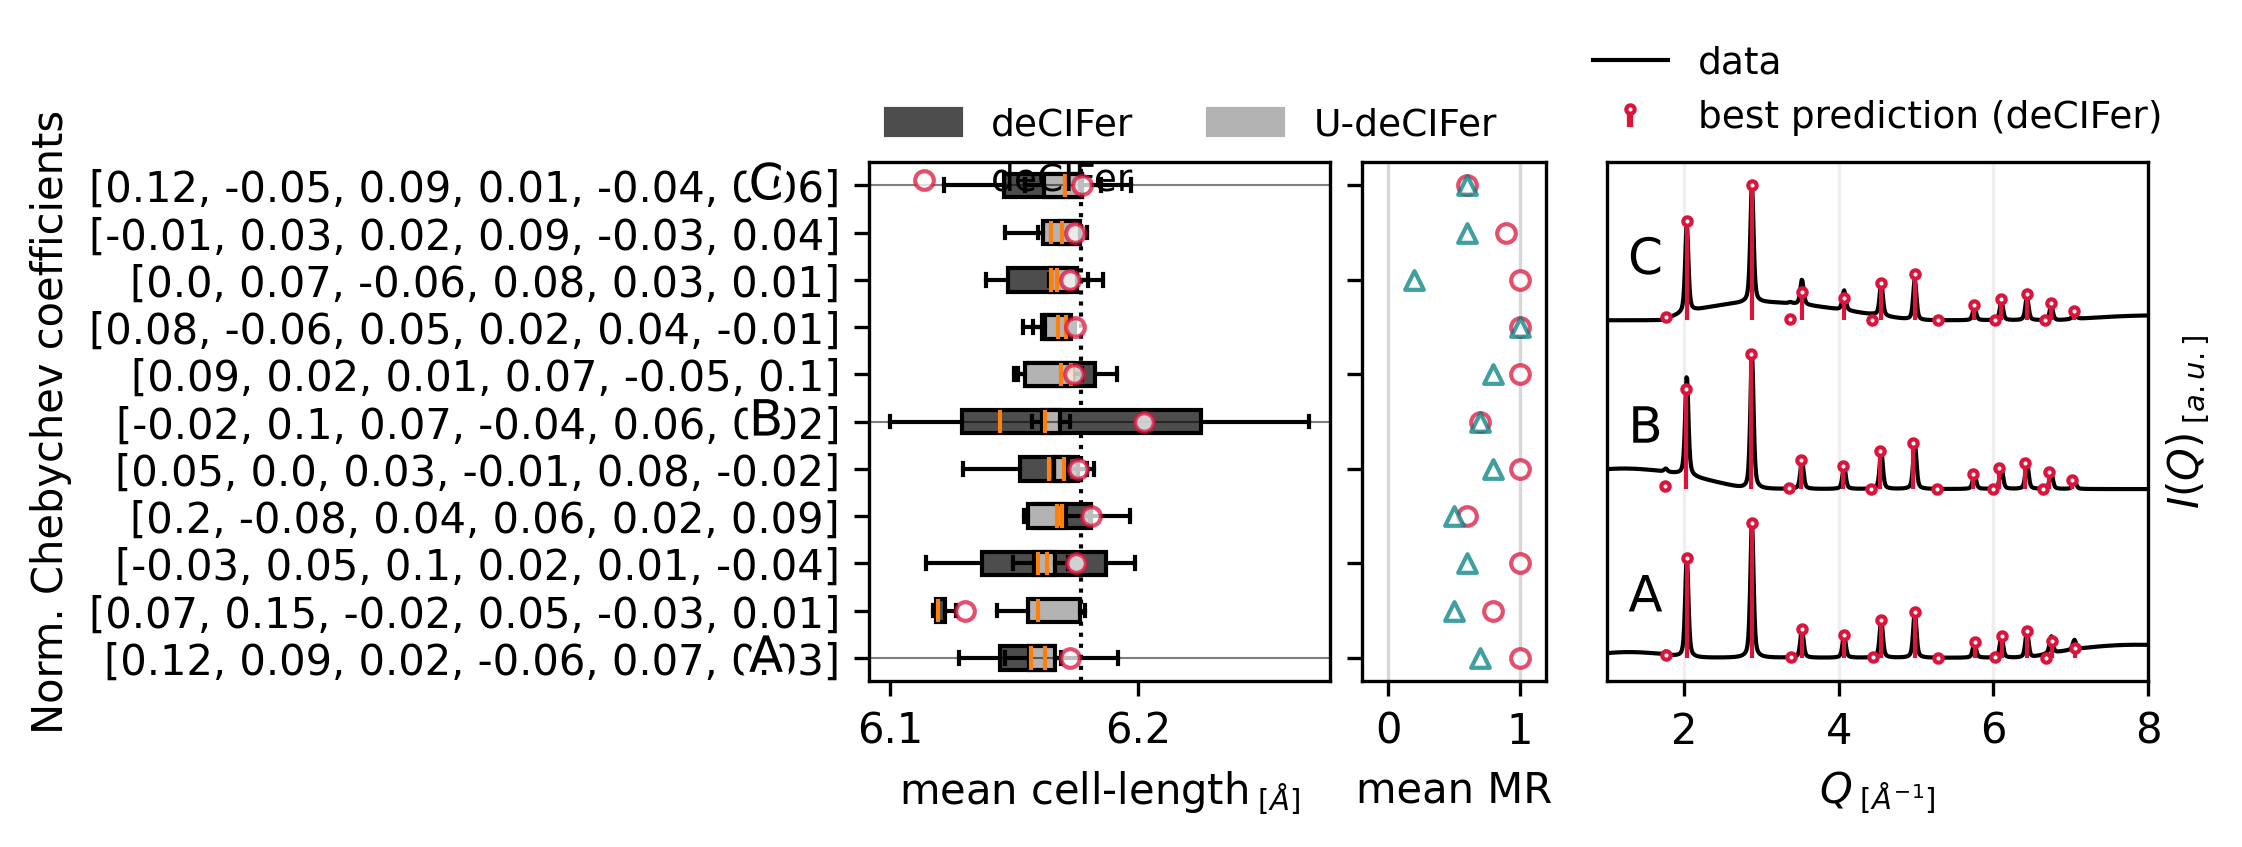

In [223]:
param_keys = [
    {
        "key": "chebychev_norm_coeffs",
        "xlabel": "Norm. Chebychev coefficients", 
        "unit": "", 
        "example_idxs": [0,5,10], 
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
        results_o,
        uresults_o,
        param_keys, 
        savepath = None,
        dpi=300, 
        figscale=1.0, 
        figlen=5.5,
        fig_height_factor=2.25,
        bbox_left=(0.7, 1.17),
        ncol_left = 2,
        bbox_right = (0.5, 1.29),
        ncol_right = 1,
        wspace_outer=0.1,
        wspace_left=0.1,
        AB_x = 6.05,
        cell_min = None,
        cell_max = None, 
        # AB_symbols = [r"$\alpha$", r"$\beta$"],
        cell_tags = ["a", "b", "c"],
        # AB_symbols=["A", "B"],
        show_mean = True,
        show_best = True,
        show_u = True,
        title_left_pad=17.0,
        show_mid = True,
        show_boxplots=True,
        ytick_size = None,
    )

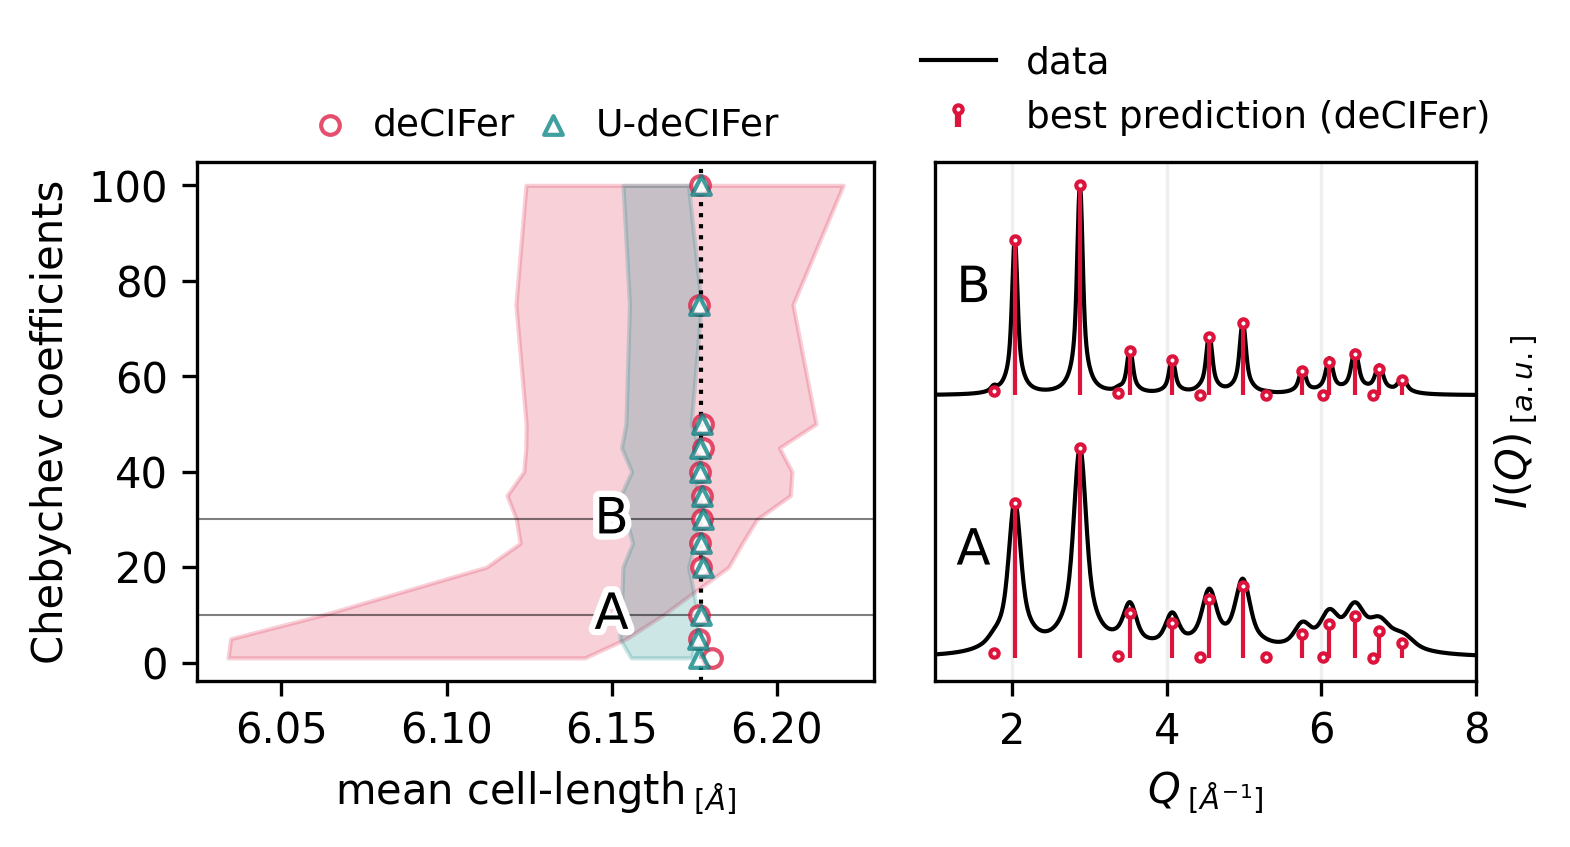

In [6]:
param_keys = [
    {
        "key": "particle_size",
        "xlabel": "Chebychev coefficients", 
        "unit": "", 
        "example_idxs": [2, 5], 
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
        results_o,
        uresults_o,
        param_keys, 
        savepath = None,
        dpi=300, 
        figscale=1.0, 
        figlen=5.5,
        fig_height_factor=2.25,
        bbox_left=(0.5, 1.17),
        ncol_left = 2,
        bbox_right = (0.5, 1.29),
        ncol_right = 1,
        wspace_outer=0.1,
        wspace_left=0.1,
        AB_x = 6.15,
        # cell_min = 5.9,
        cell_max = None, 
        # AB_symbols = [r"$\alpha$", r"$\beta$"],
        cell_tags = ["a", "b", "c"],
        # AB_symbols=["A", "B"],
        show_mean = True,
        show_best = True,
        show_u = True,
        title_left_pad=17.0,
        show_mid = False,
        show_boxplots=False
    )

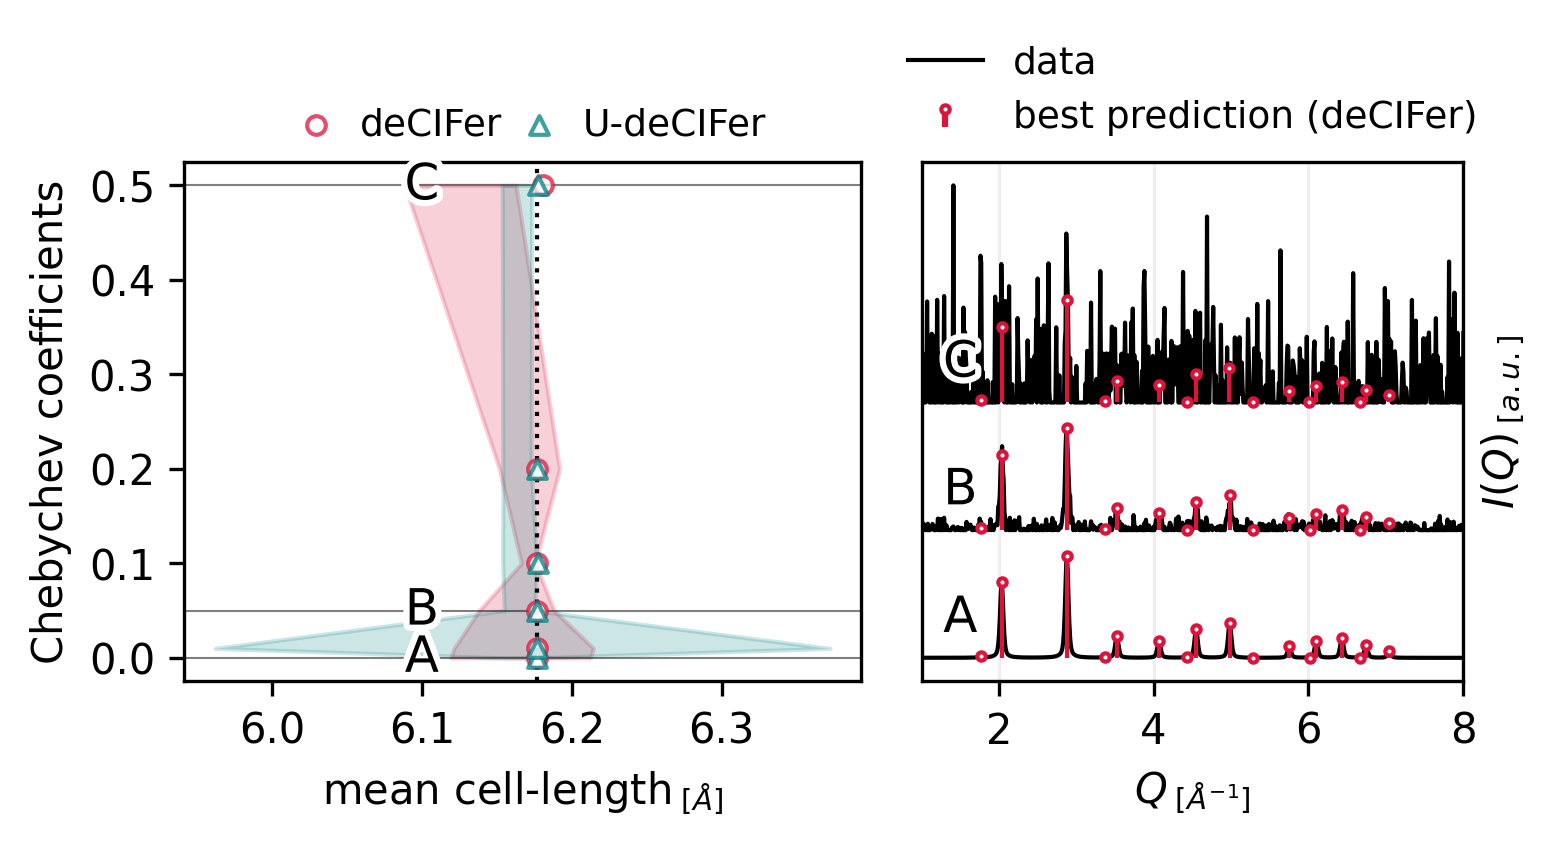

In [13]:
param_keys = [
    {
        "key": "noise",
        "xlabel": "Chebychev coefficients", 
        "unit": "", 
        "example_idxs": [0,2,5], 
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
        results_o,
        uresults_o,
        param_keys, 
        savepath = None,
        dpi=300, 
        figscale=1.0, 
        figlen=5.5,
        fig_height_factor=2.25,
        bbox_left=(0.5, 1.17),
        ncol_left = 2,
        bbox_right = (0.5, 1.29),
        ncol_right = 1,
        wspace_outer=0.1,
        wspace_left=0.1,
        AB_x = 6.10,
        # cell_min = 5.9,
        cell_max = None, 
        # AB_symbols = [r"$\alpha$", r"$\beta$"],
        cell_tags = ["a", "b", "c"],
        # AB_symbols=["A", "B"],
        show_mean = True,
        show_best = True,
        show_u = True,
        title_left_pad=17.0,
        show_mid = False,
        show_boxplots=False
    )

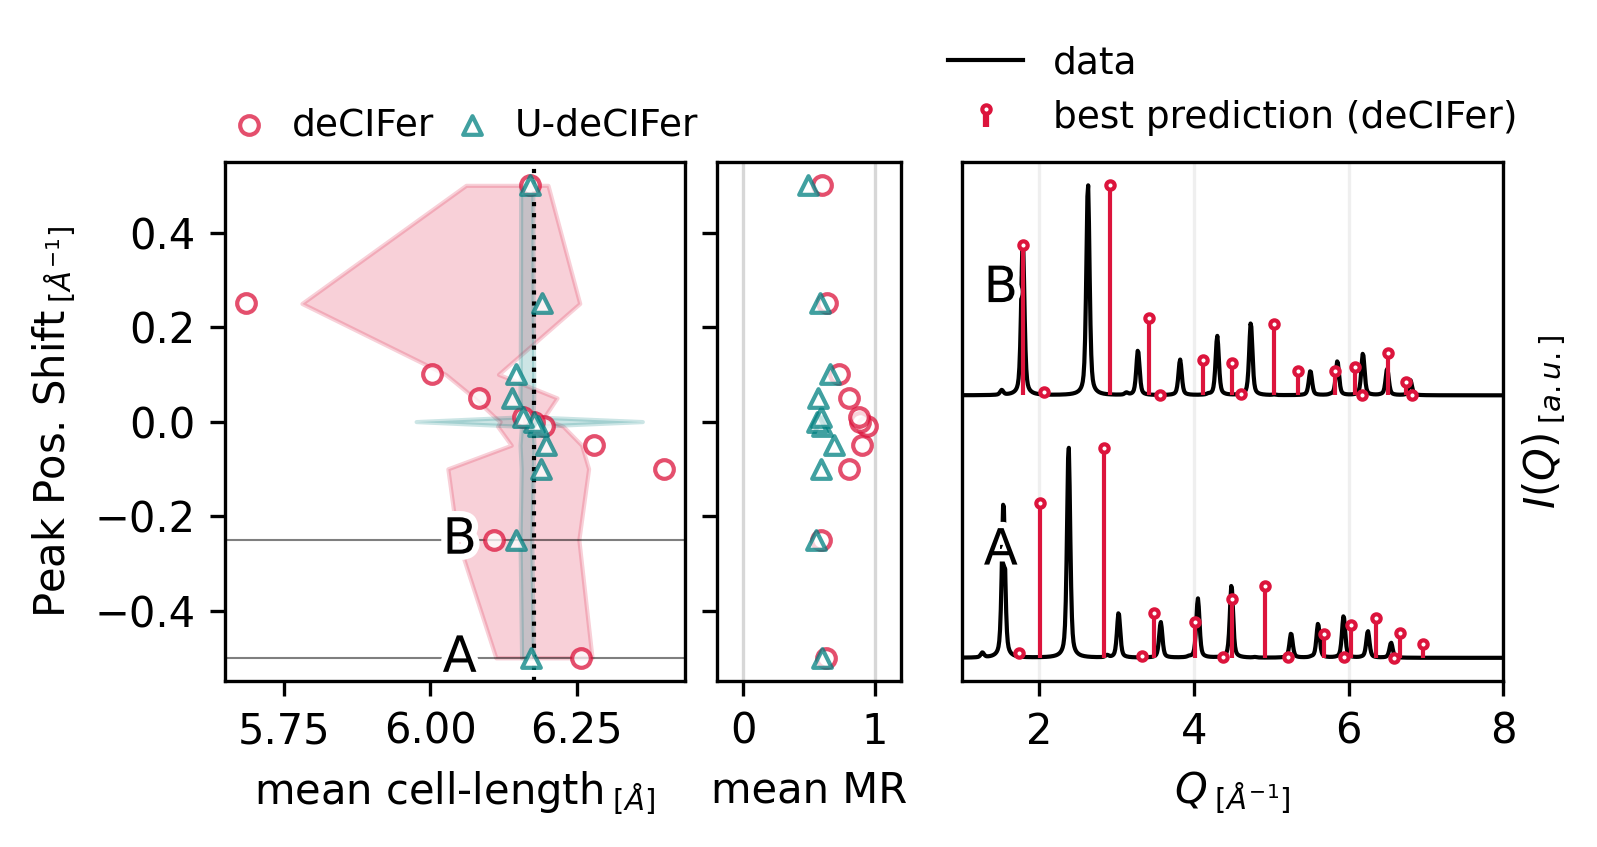

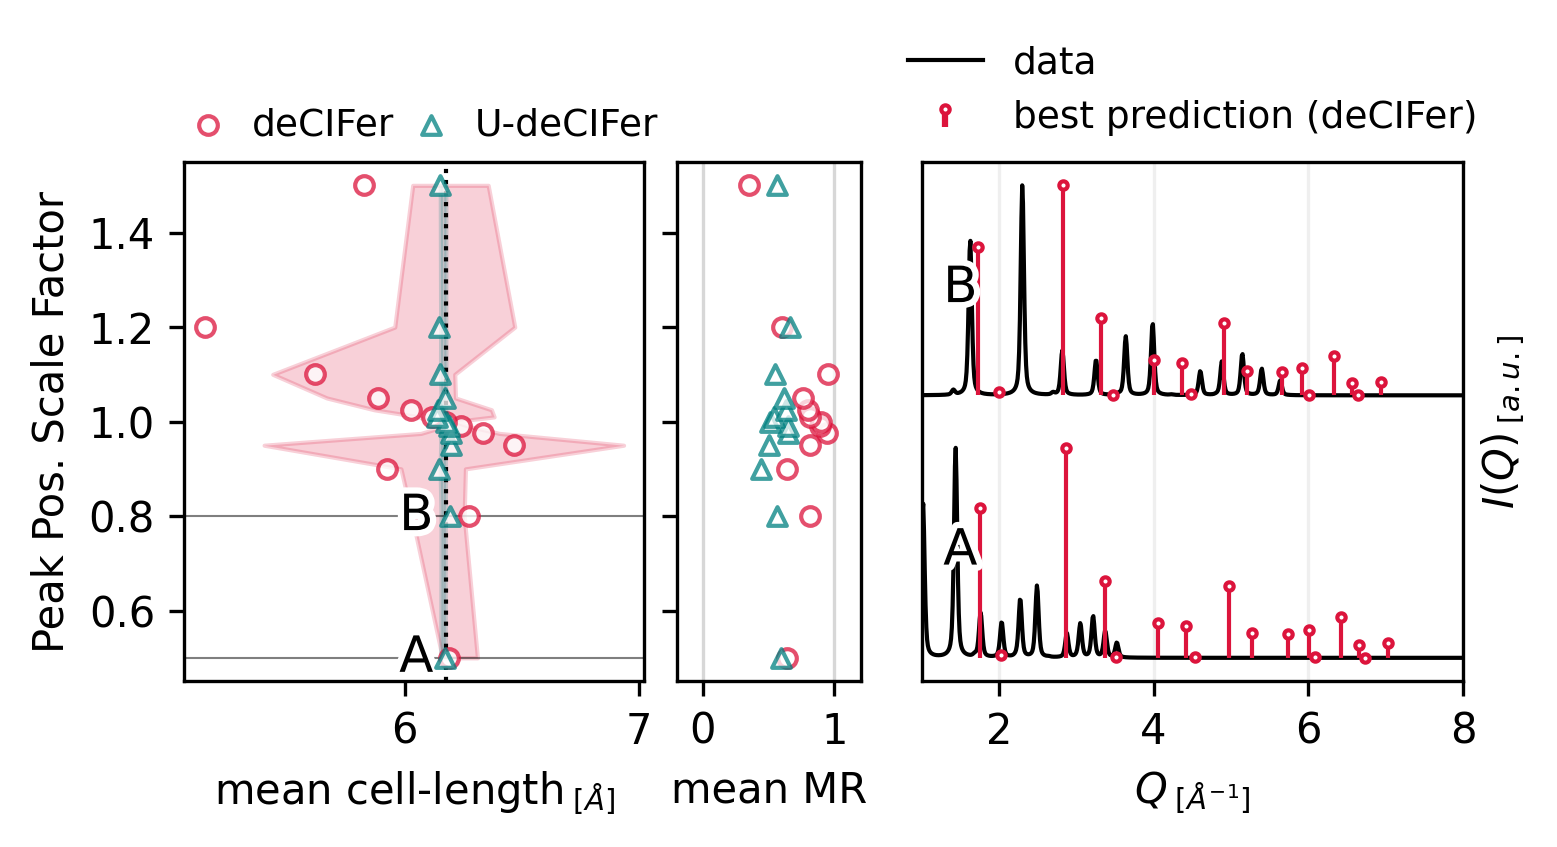

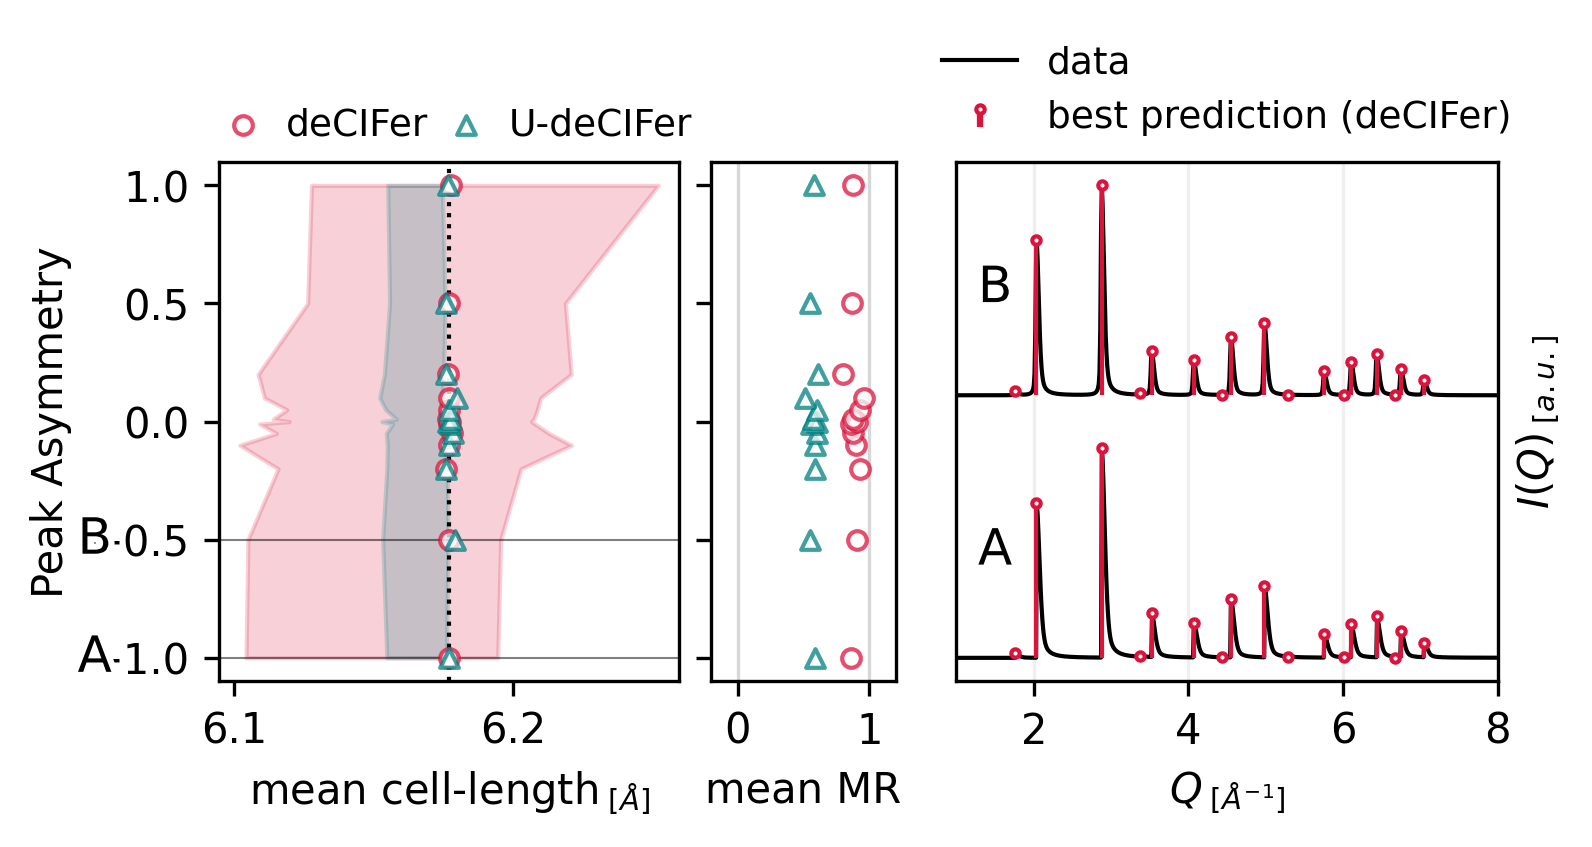

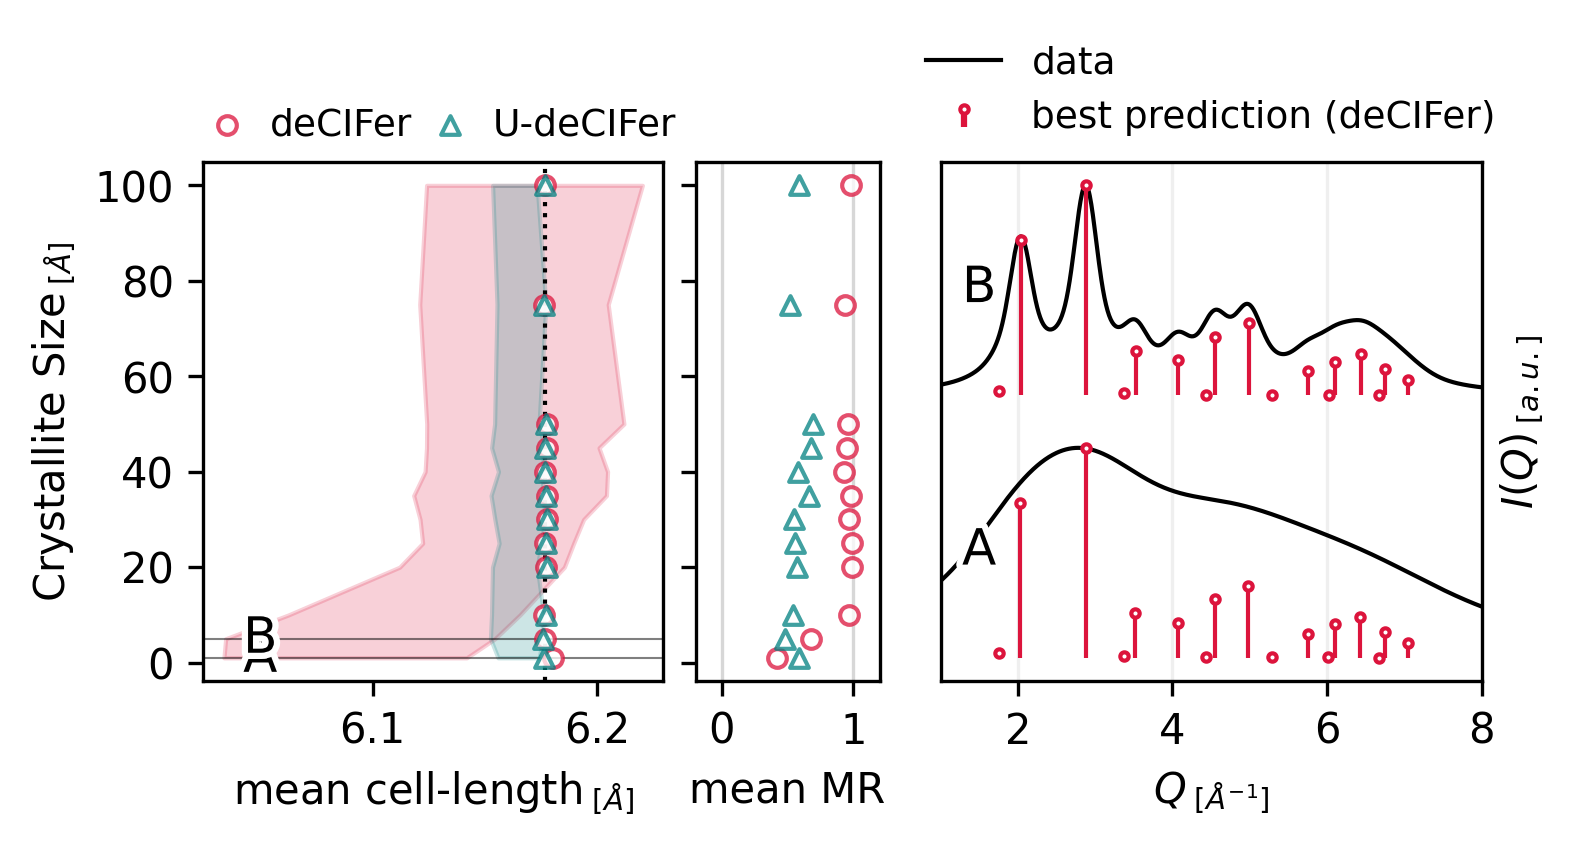

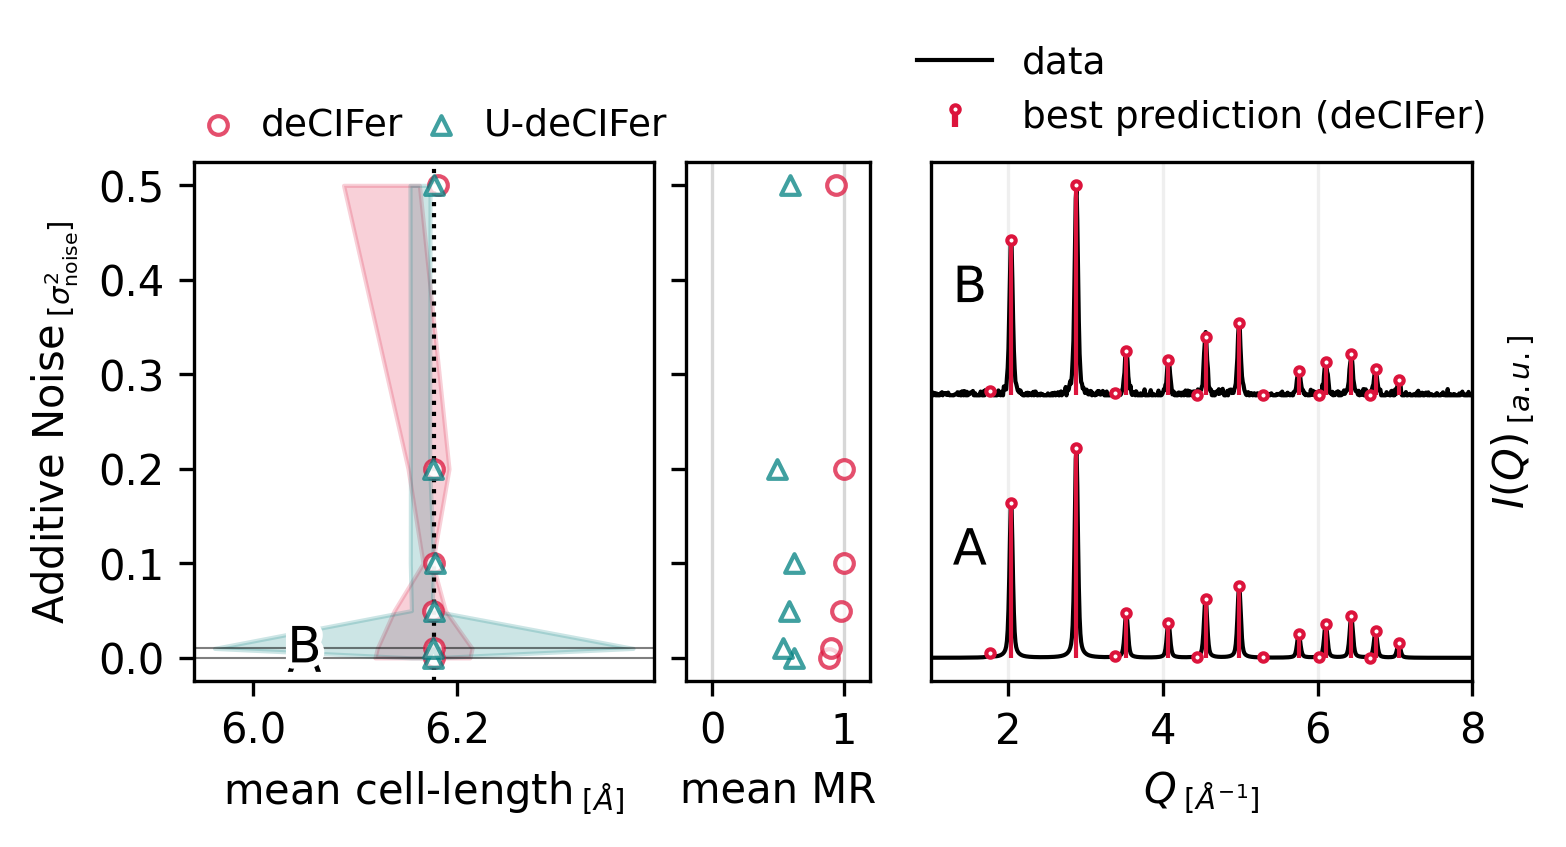

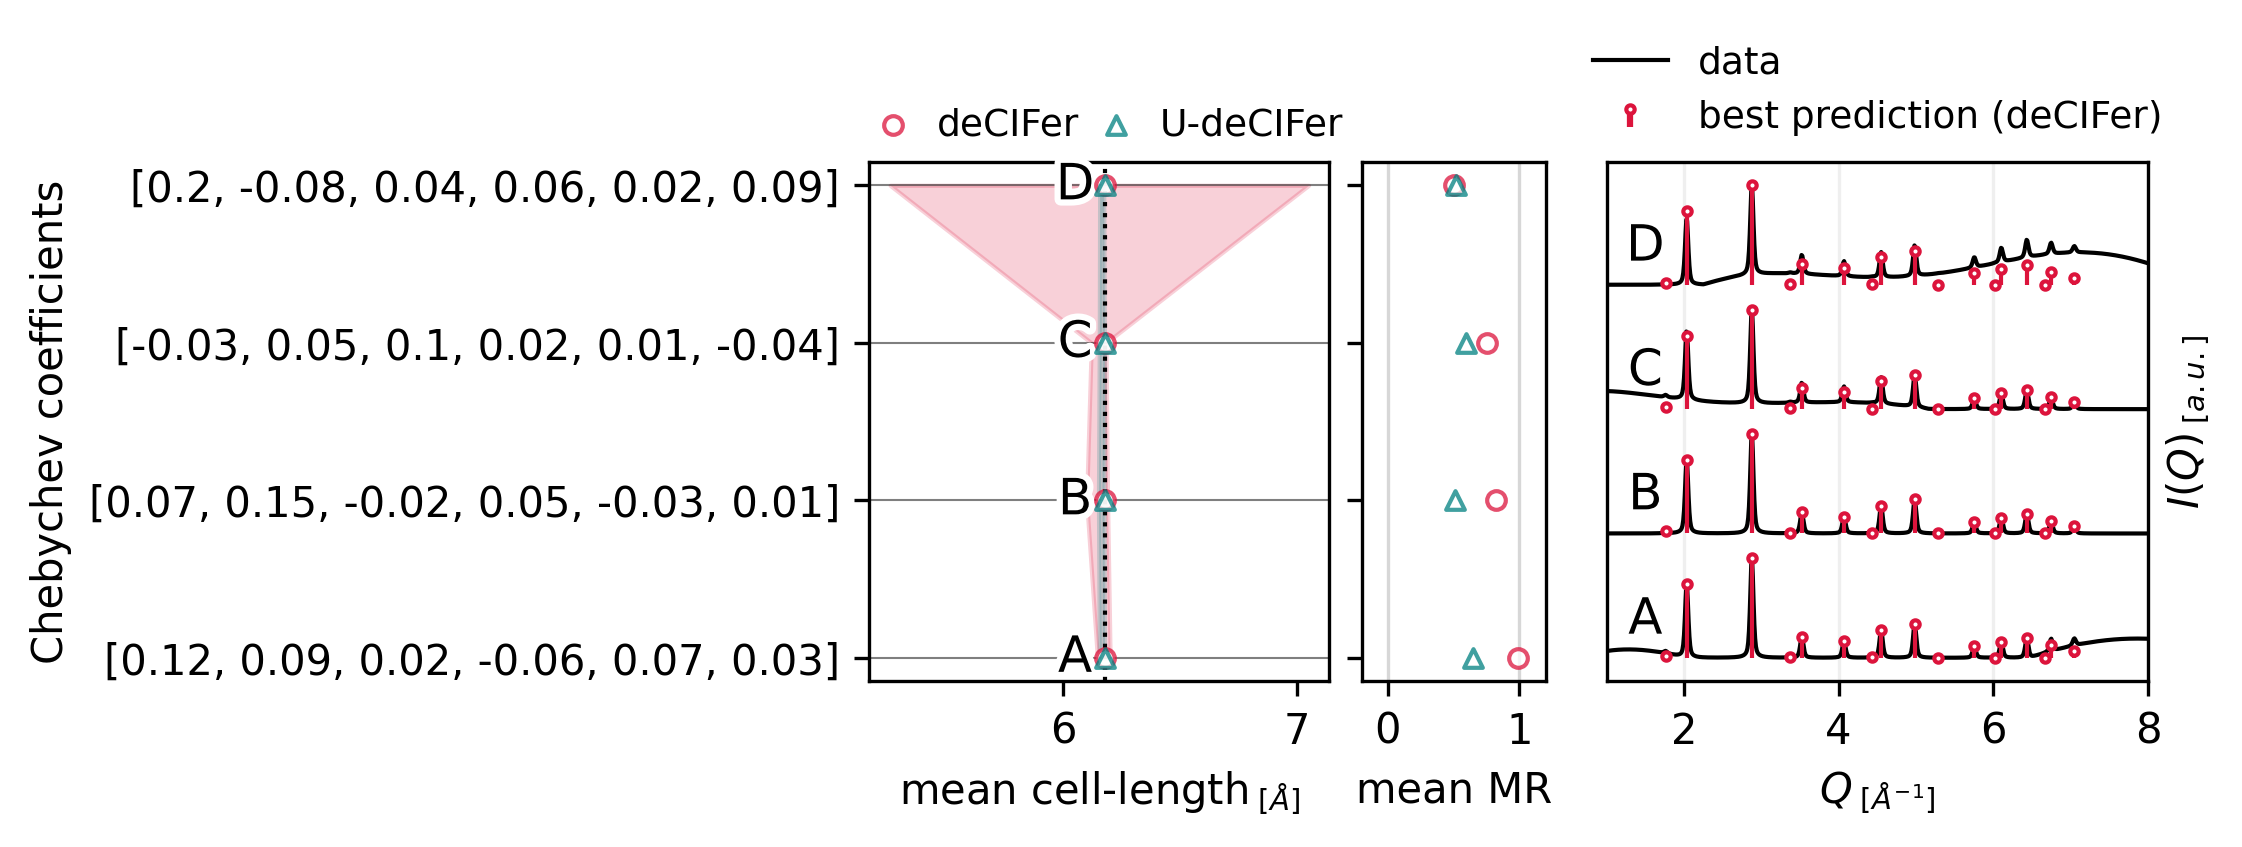

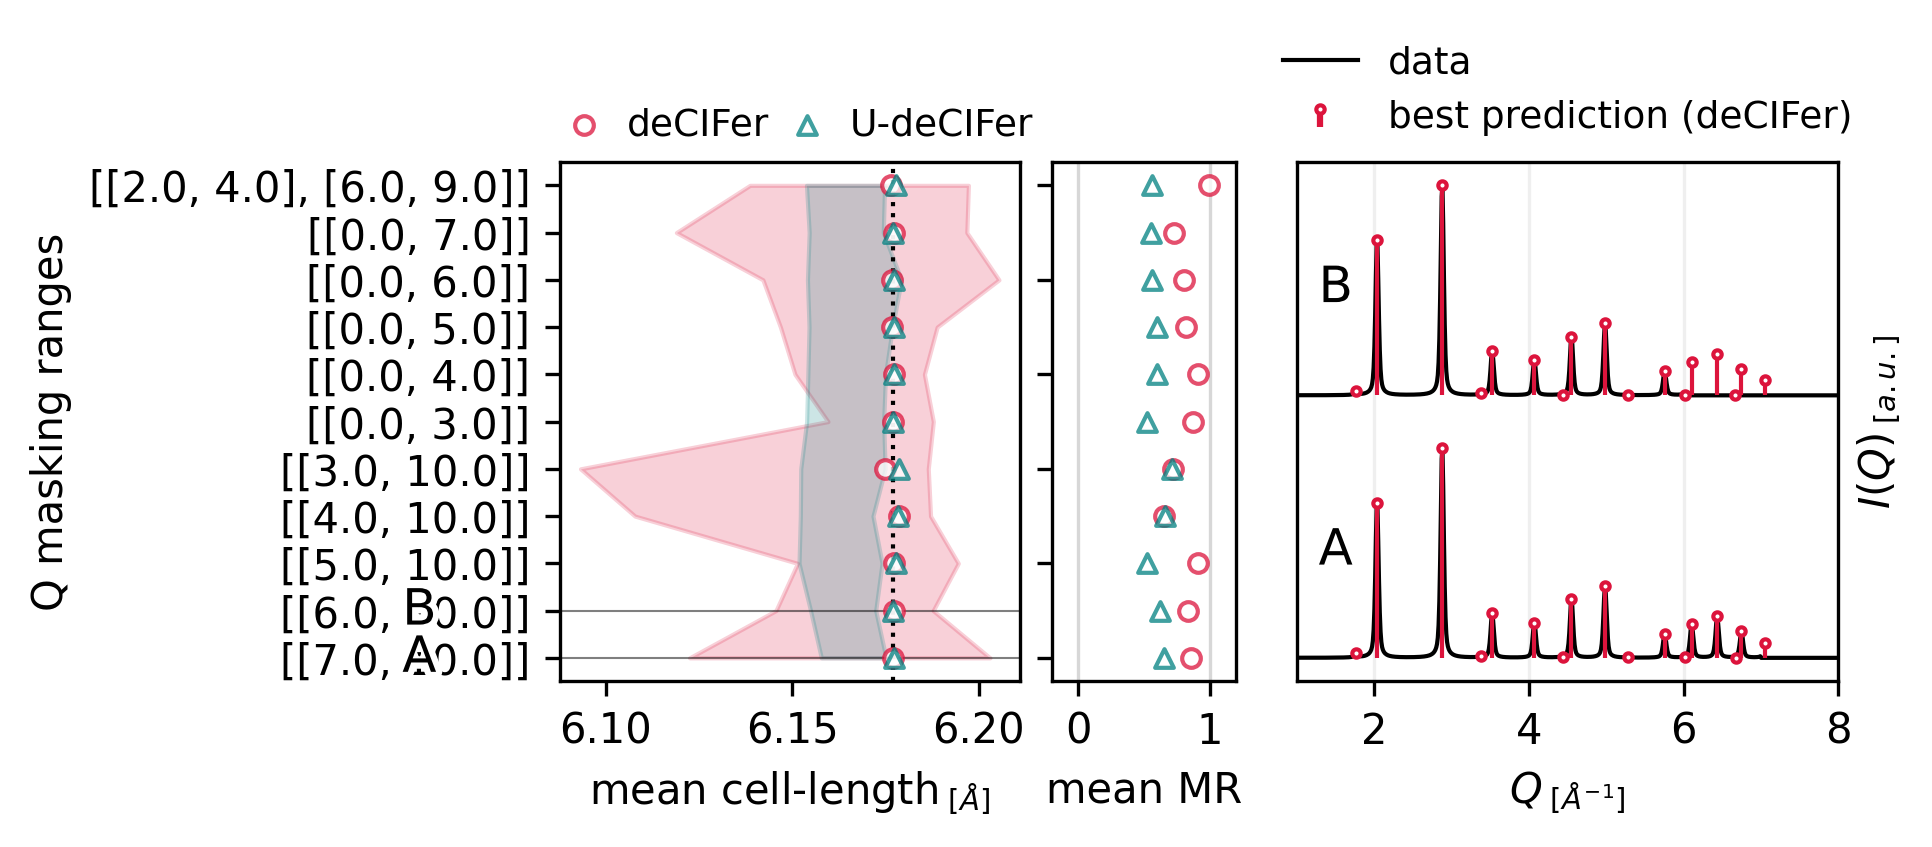

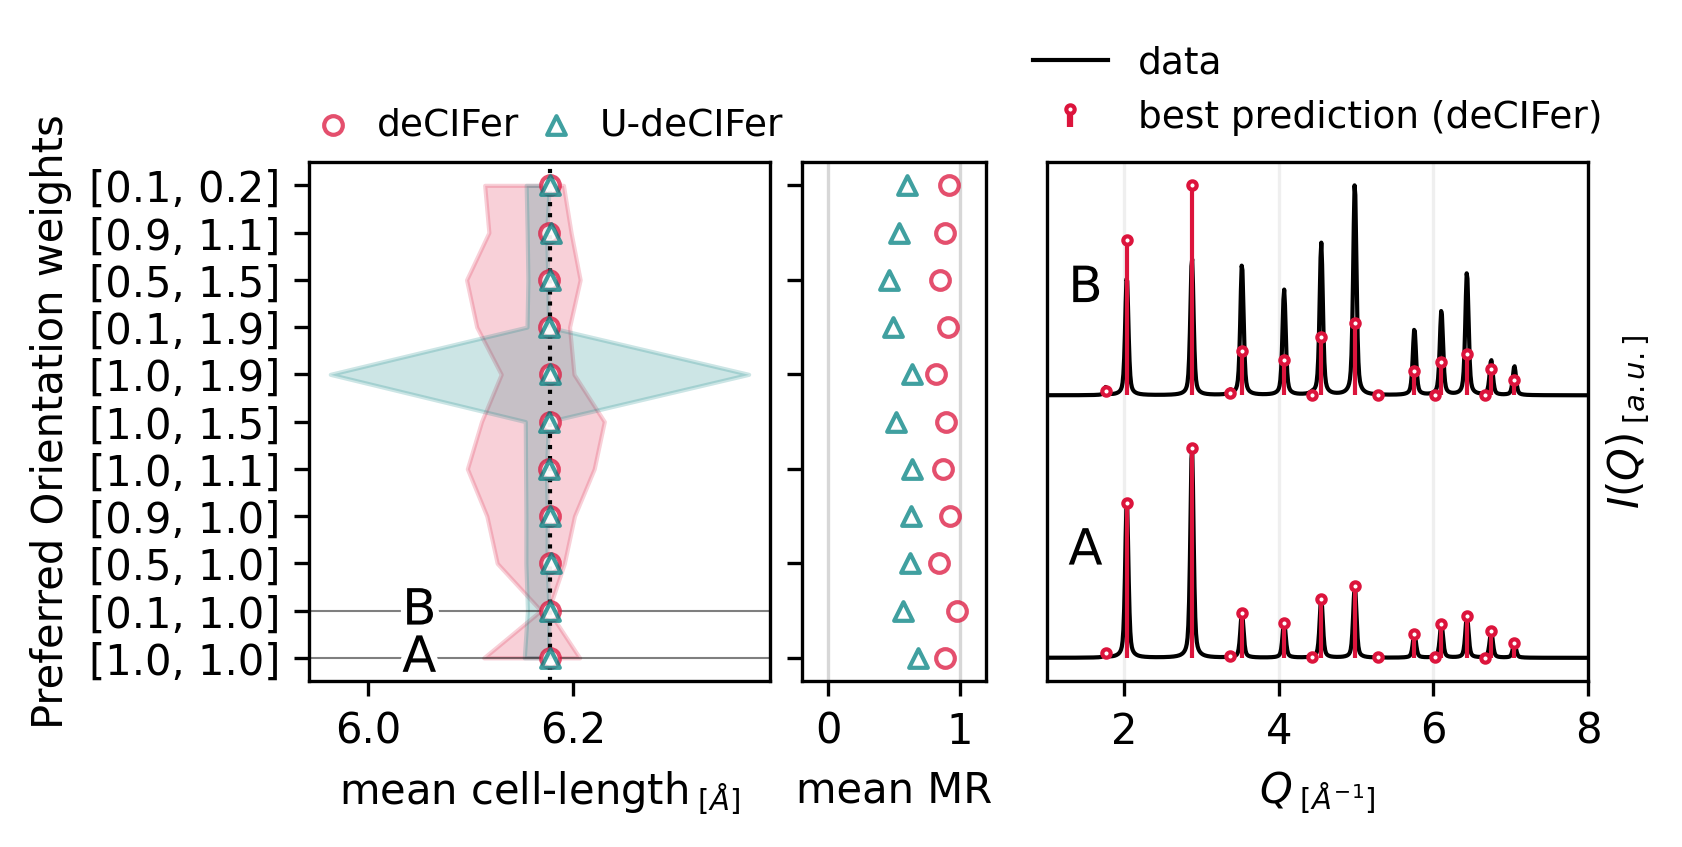

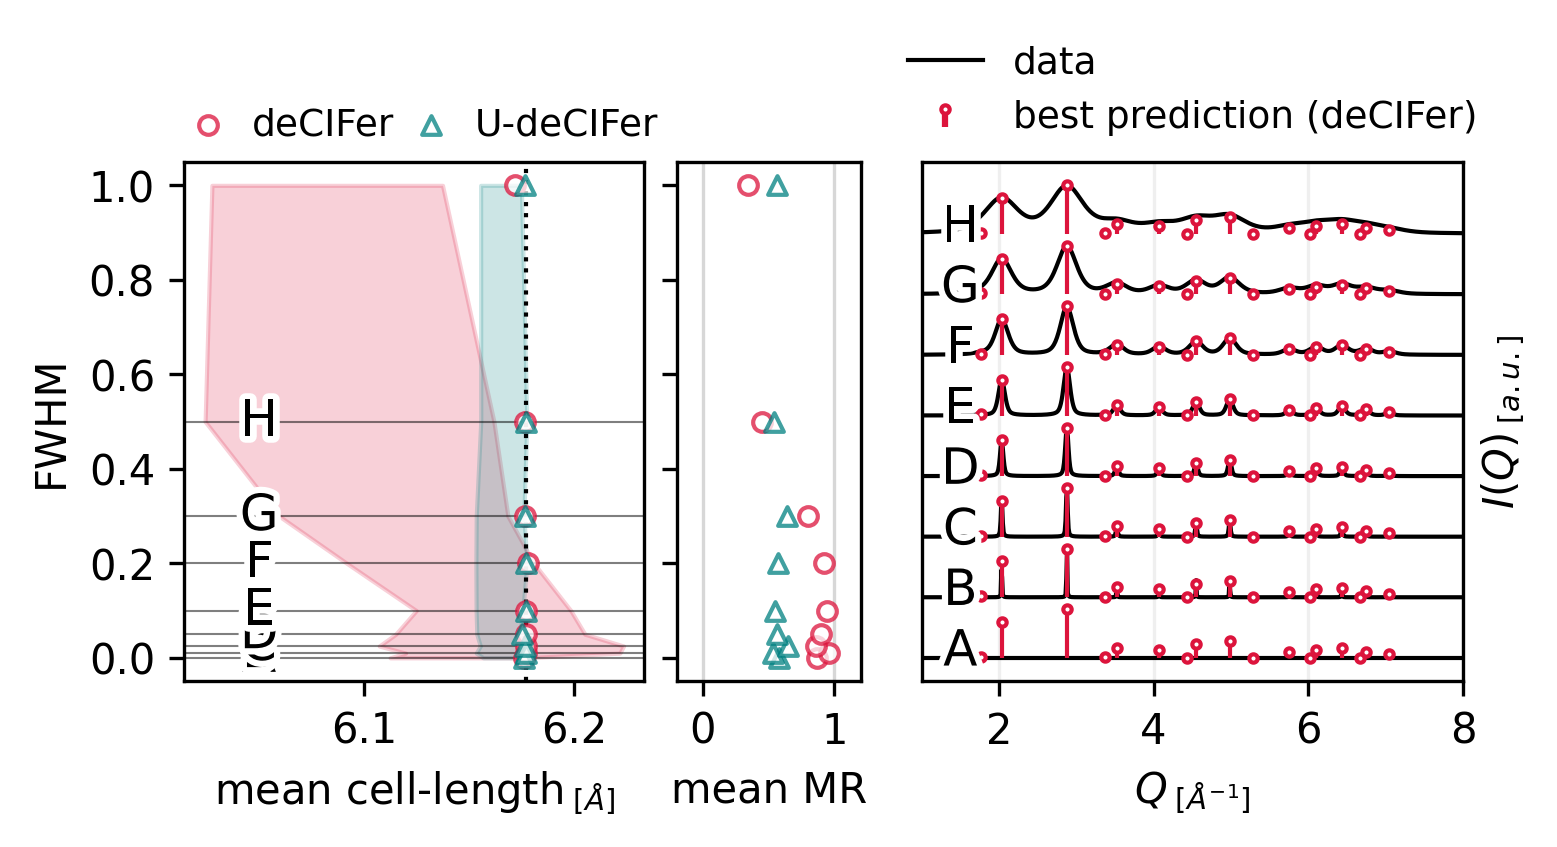

In [15]:
param_keys = [
 {
        "key": "q_shift", 
        "title": "Peak Pos. Shift", 
        "xlabel": "Peak Pos. Shift", 
        "unit": r"$_{\;[Å^{-1}]}$", 
        "example_1_idx": 2, 
        "example_2_idx": 8,
        "param_symbol_top": r"$\lhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\rhd\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "q_scale", 
        "title": "Peak Pos. Scaling", 
        "xlabel": "Peak Pos. Scale Factor", 
        "unit": "", 
        "example_1_idx": 3, 
        "example_2_idx": 7,
        "param_symbol_top": r"$\rhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\lhd\;\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "peak_asymmetry", 
        "title": "Peak Asymmetry", 
        "xlabel": "Peak Asymmetry", 
        "unit": "", 
        "example_1_idx": 0, 
        "example_2_idx": 8,
        "example_none_idx": 5,
        "param_symbol_top": r"$/\!|$",
        "param_symbol_top_rot": 18.5,
        "param_symbol_bot": r"$|\!\backslash$",
        "param_symbol_bot_rot": -18.5,
        "param_symbol_size": 20
    },
        {
        "key": "particle_size", 
        "title": "Crystallite Size", 
        "xlabel": "Crystallite Size", 
        "unit": r"$_{\;[Å]}$", 
        "example_1_idx": 1, 
        "example_2_idx": 8,
        "example_none_idx": 2,
        "param_symbol_top": r"o",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "noise", 
        "title": "Gaussian Noise", 
        "xlabel": "Additive Noise", 
        "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
        "example_1_idx": 2, 
        "example_2_idx": 12,
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {
        "key": "chebychev_norm_coeffs",
        "xlabel": "Chebychev coefficients", 
        "unit": "", 
        "example_idxs": [0,1,2,3],
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {        
        "key": "mask_ranges",
        "title": "Gaussian Noise", 
        "xlabel": "Q masking ranges", 
        "unit": "", 
        "example_1_idx": 2, 
        "example_2_idx": 3,
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
    {        
        "key": "preferred_orientation_range",
        "title": "Gaussian Noise", 
        "xlabel": "Preferred Orientation weights", 
        "unit": "", 
        "example_1_idx": 2, 
        "example_2_idx": 3,
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },

    {        
        "key": "base_fwhm", 
        "title": "Instrumental Broadening", 
        "xlabel": "FWHM", 
        "unit": "", 
        "example_idxs": [0,1,2,3,4,5,6,7],
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

for param_single_dict in param_keys:
    pk = [param_single_dict]

    ablation_fig(
        results_o,
        uresults_o,
        pk, 
        savepath = None,
        dpi=300, 
        figscale=1.0, 
        figlen=5.5, 
        fig_height_factor=2.25,
        cell_min = None,
        cell_max = None, 
        bbox_left=(0.5, 1.17),
        ncol_left = 2,
        bbox_right = (0.5, 1.29),
        ncol_right = 1,
        wspace_outer=0.1,
        wspace_left=0.1,
        AB_x = 6.05,
        # AB_symbols = [r"$\alpha$", r"$\beta$"],
        cell_tags = ["a", "b", "c"],
        show_mean = True,
        show_best = True,
        title_left_pad=17.0,
        show_mid = True,
        show_u = True
    )

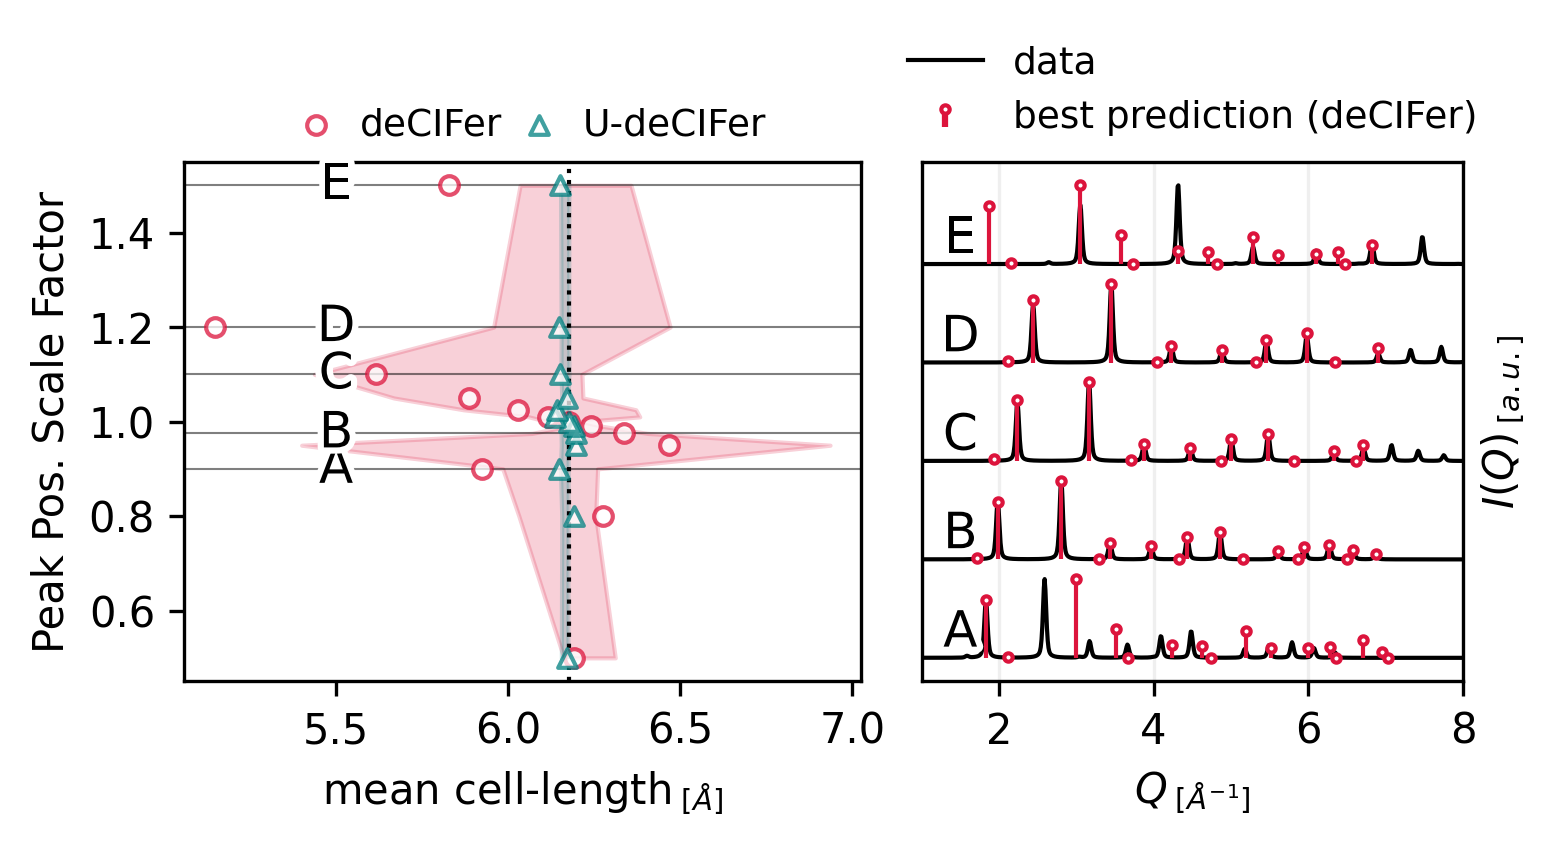

In [16]:
param_keys = [
    {
        "key": "q_scale", 
        "title": "Peak Pos. Scaling", 
        "xlabel": "Peak Pos. Scale Factor", 
        "unit": "", 
        "example_idxs": [2,4,10,11,12],
        "param_symbol_top": r"$\rhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\lhd\;\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
    results_o,
    uresults_o,
    param_keys, 
    savepath = "ablation_peak_scale.png",
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None,
    cell_max = None, 
    bbox_left=(0.5, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 5.5,
    # AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left_pad=17.0,
    show_mid = False,
    show_u = True
)

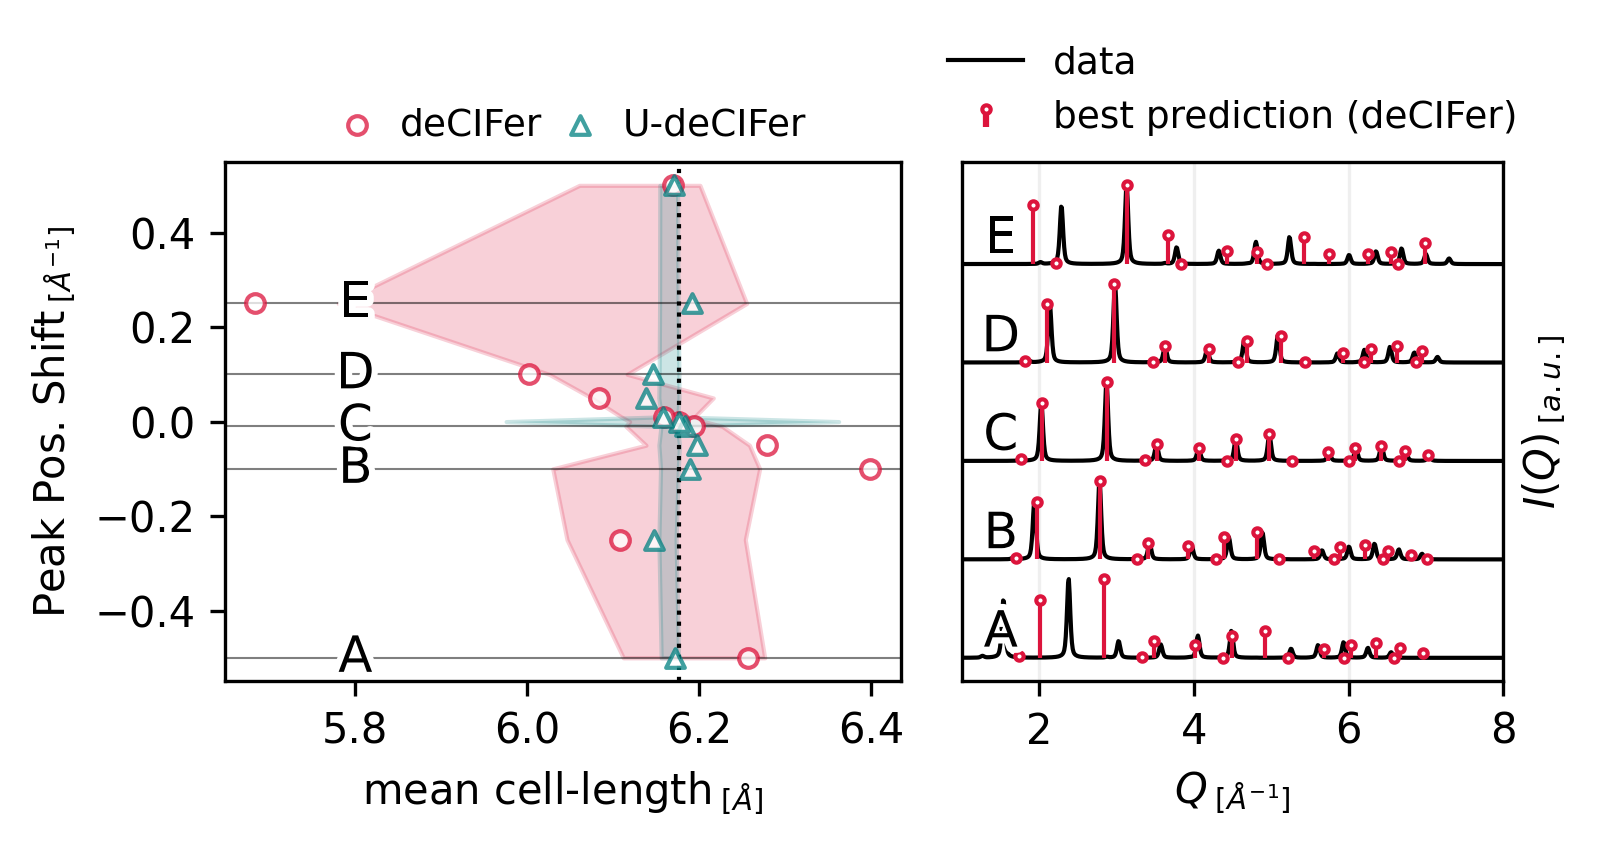

In [5]:
param_keys = [
 {
        "key": "q_shift", 
        "title": "Peak Pos. Shift", 
        "xlabel": "Peak Pos. Shift", 
        "unit": r"$_{\;[Å^{-1}]}$", 
        "example_idxs": [0,2,4,8,9], 
        "param_symbol_top": r"$\lhd\lhd$",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"$\rhd\rhd$",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
    results_o,
    uresults_o,
    param_keys, 
    savepath = "ablation_peak_shift.png",
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None,
    cell_max = None, 
    bbox_left=(0.5, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 5.8,
    # AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left_pad=17.0,
    show_mid = False,
    show_u = True
)

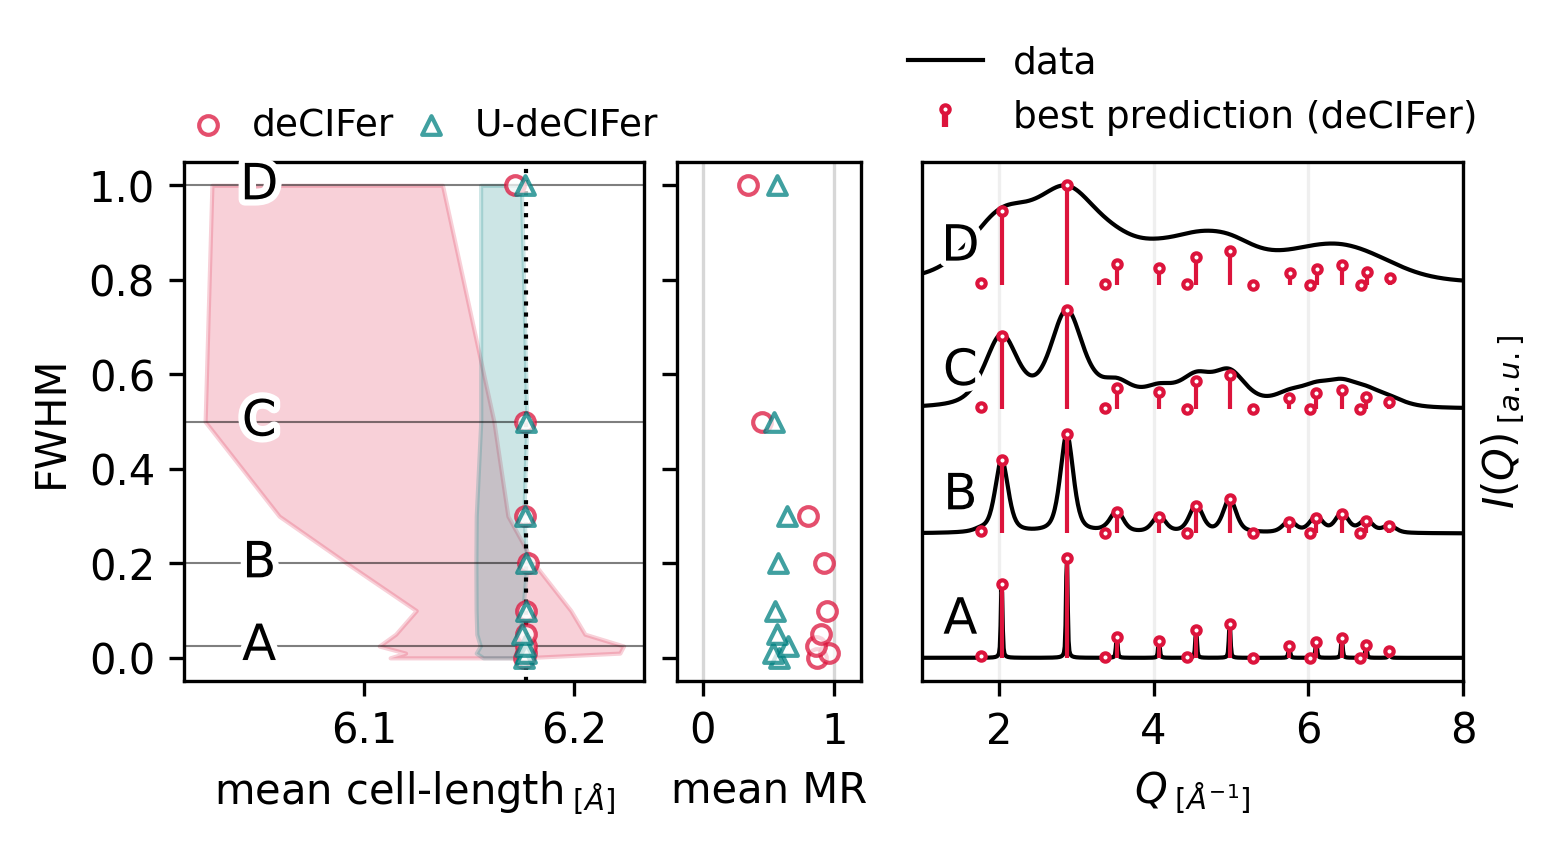

In [6]:
param_keys = [
    {        
        "key": "base_fwhm", 
        "title": "Instrumental Broadening", 
        "xlabel": "FWHM", 
        "unit": "", 
        "example_idxs": [2,5,7,8],
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
    results_o,
    uresults_o,
    param_keys, 
    savepath = "ablation_fwhm.png",
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None,
    cell_max = None, 
    bbox_left=(0.5, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 6.05,
    # AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left_pad=17.0,
    show_mid = True,
    show_u = True
)

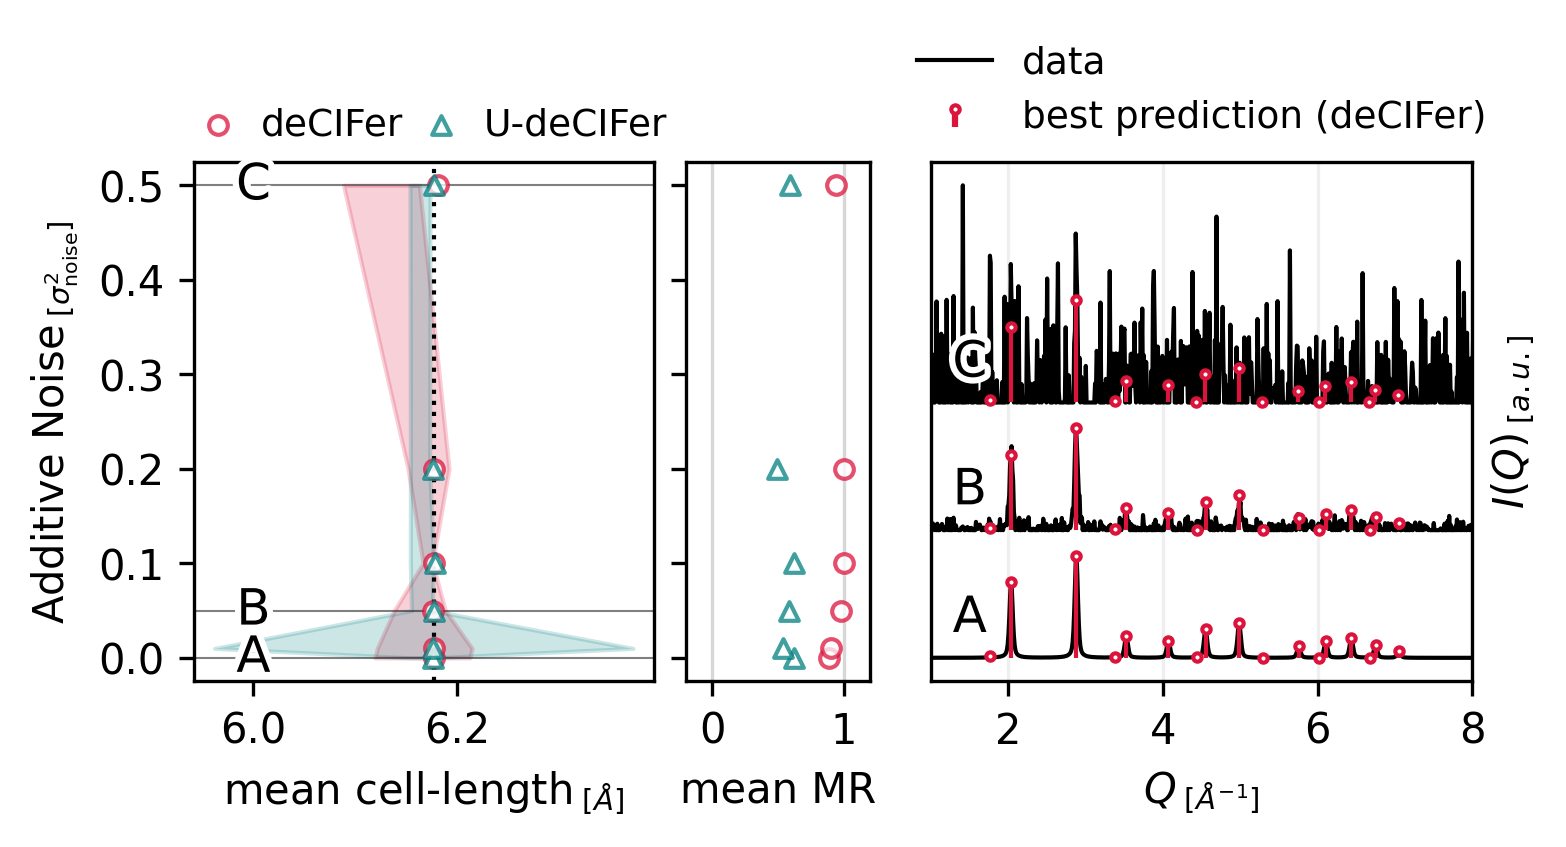

In [7]:
param_keys = [
    {
        "key": "noise", 
        "title": "Gaussian Noise", 
        "xlabel": "Additive Noise", 
        "unit": r"$_{\;[\sigma_{\mathrm{noise}}^2]}$", 
       "example_idxs": [0,2,5], 
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
    results_o,
    uresults_o,
    param_keys, 
    savepath = "ablation_noise.png",
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None,
    cell_max = None, 
    bbox_left=(0.5, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 6.0,
    # AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left_pad=17.0,
    show_mid = True,
    show_u = True
)

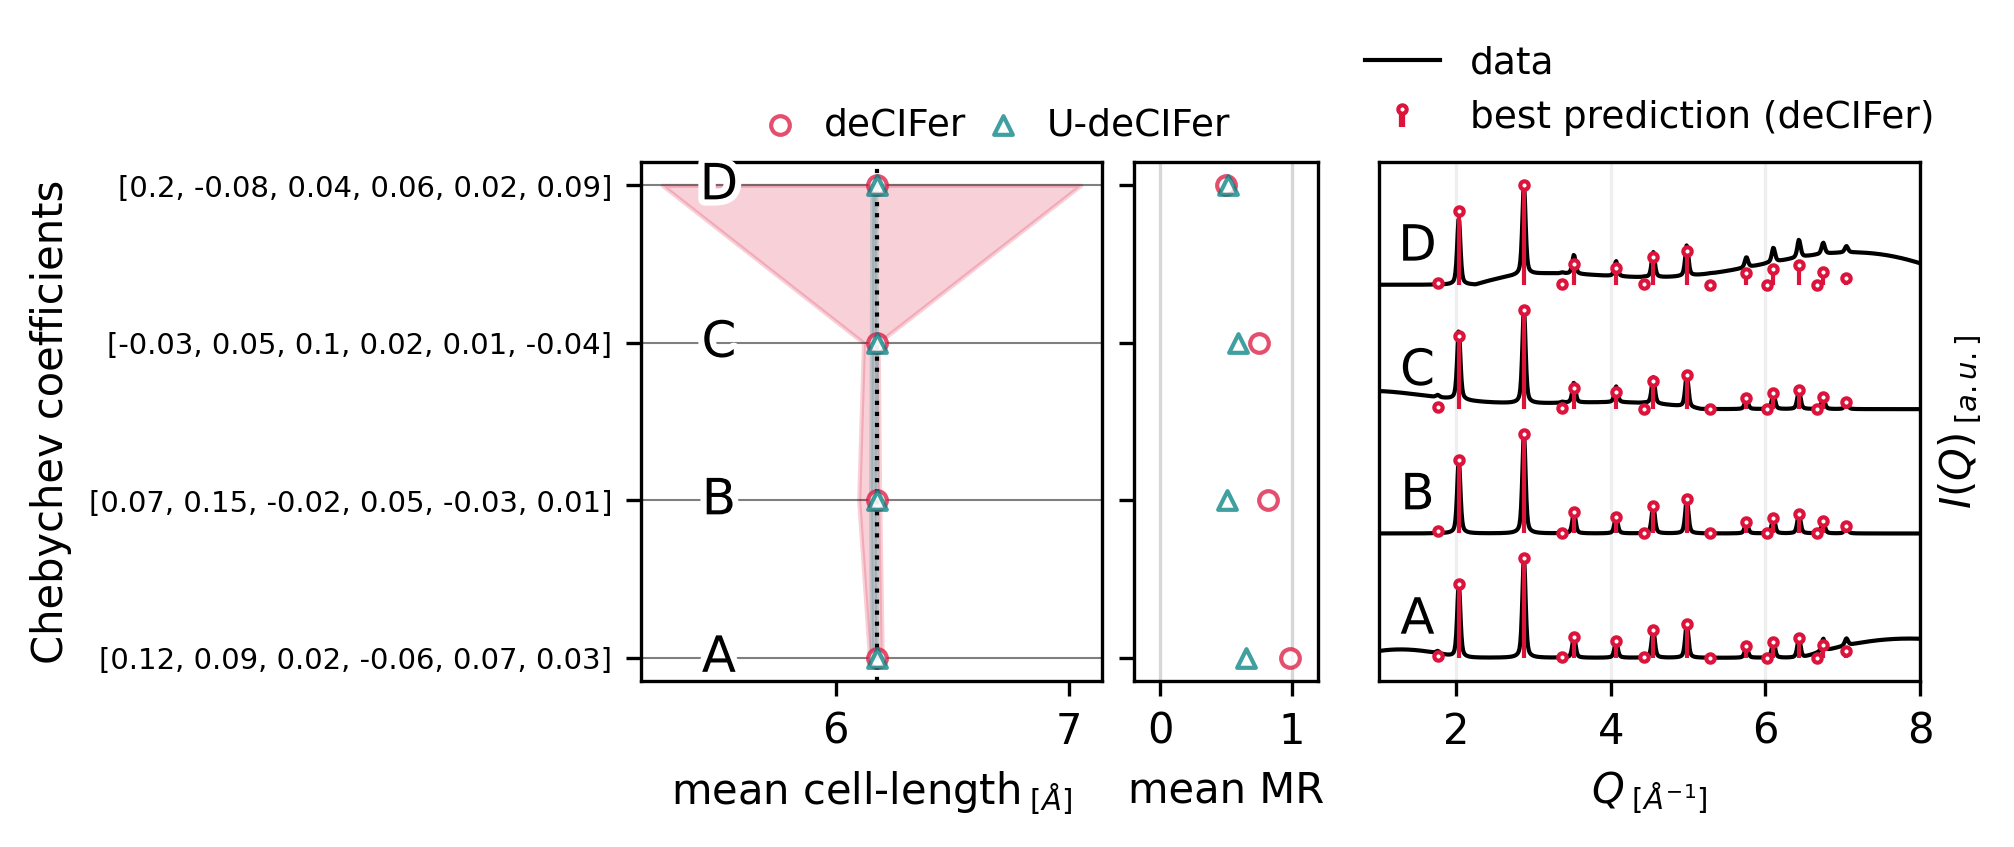

In [8]:
param_keys = [
    {
        "key": "chebychev_norm_coeffs",
        "xlabel": "Chebychev coefficients", 
        "unit": "", 
        "example_idxs": [0,1,2,3],
        "example_none_idx": 5,
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
    results_o,
    uresults_o,
    param_keys, 
    savepath = "ablation_background.png",
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None,
    cell_max = None, 
    bbox_left=(0.75, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 5.5,
    # AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left_pad=17.0,
    show_mid = True,
    show_u = True,
    show_boxplots=False,
    ytick_size = 7,
    
)

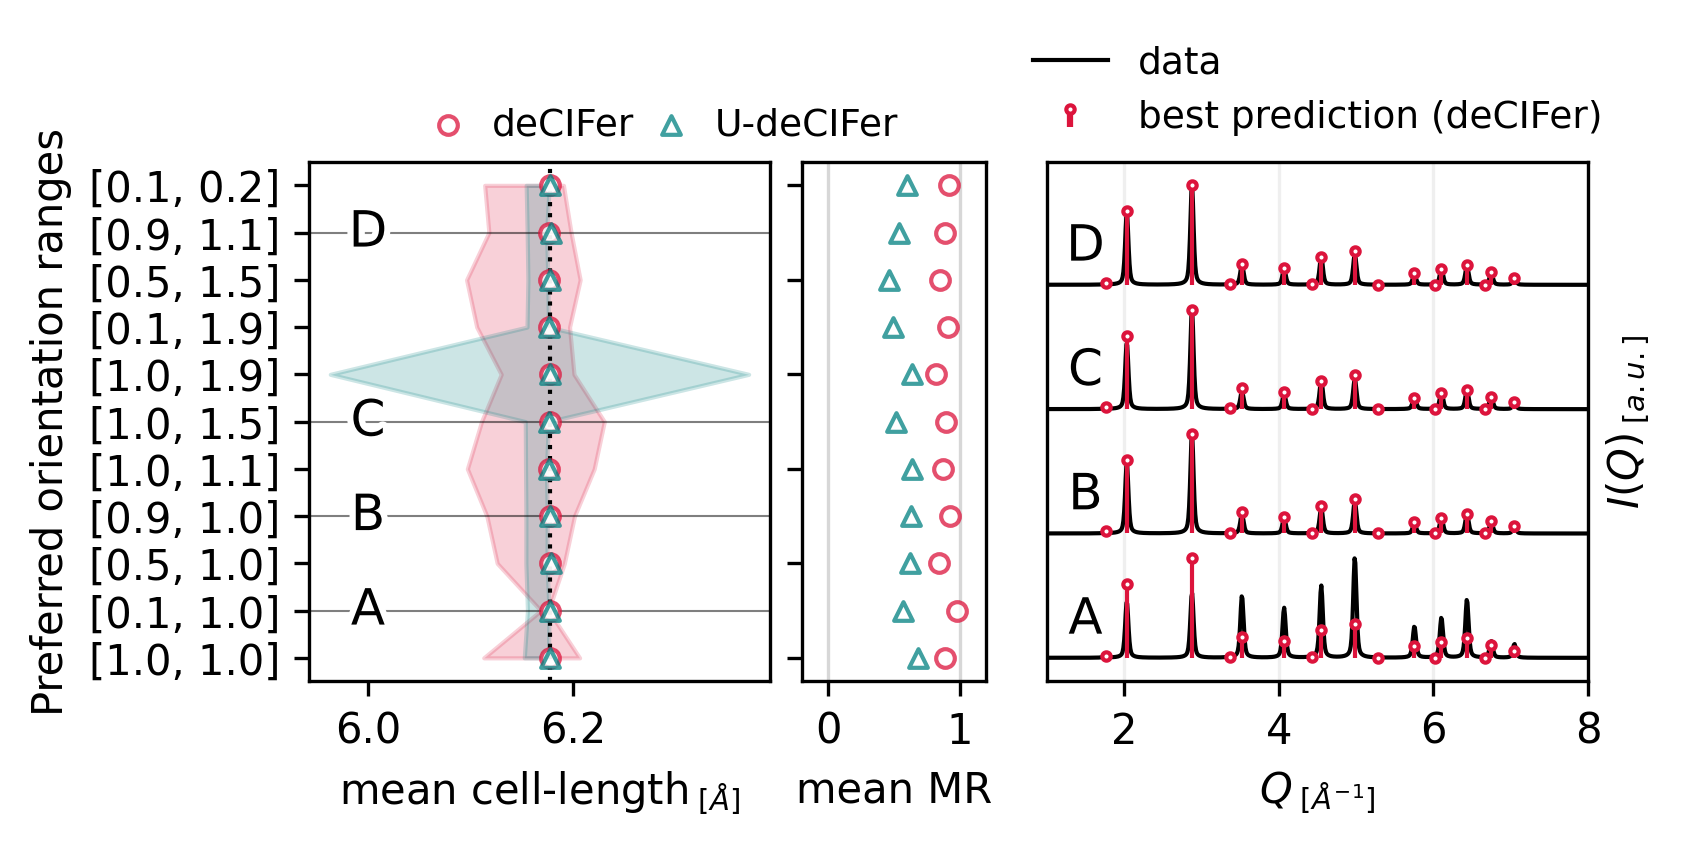

In [9]:
param_keys = [
    {        
        "key": "preferred_orientation_range",
        "title": "Gaussian Noise", 
        "xlabel": "Preferred orientation ranges", 
        "unit": "", 
        "example_idxs": [1,3,5,9],
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
    results_o,
    uresults_o,
    param_keys, 
    savepath = "ablation_orientation.png",
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None,
    cell_max = None, 
    bbox_left=(0.75, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 6.0,
    # AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left_pad=17.0,
    show_mid = True,
    show_u = True,
    show_boxplots=False,
    ytick_size = None,
    
)

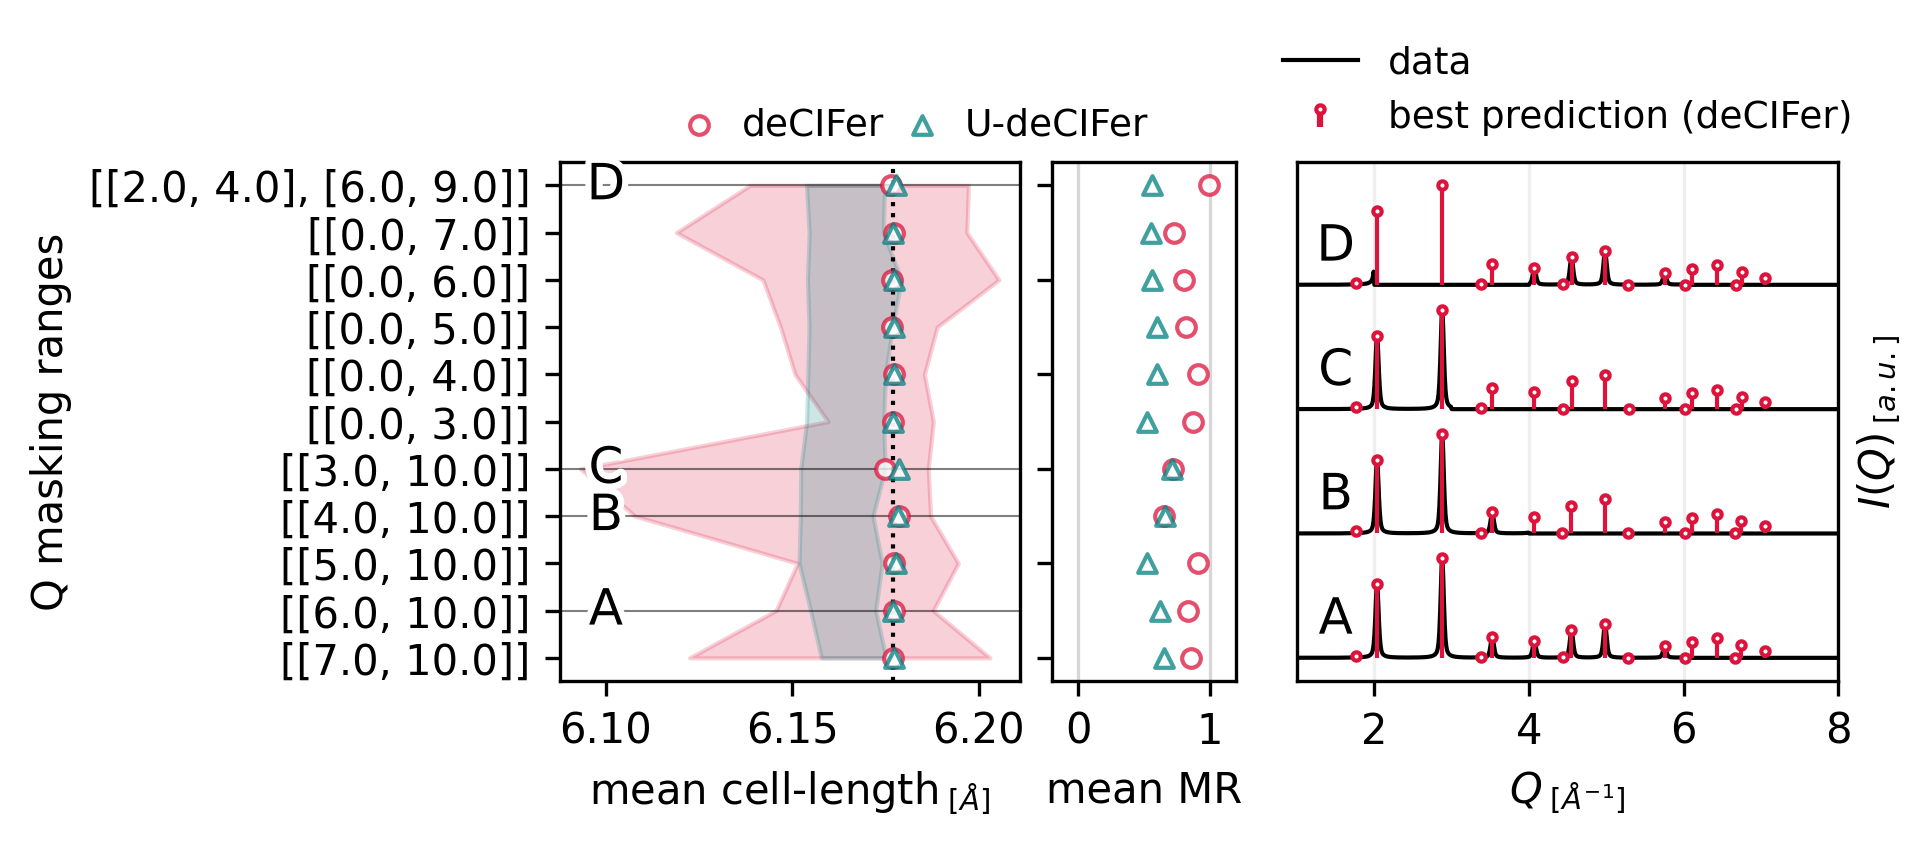

In [10]:
param_keys = [
    {        
        "key": "mask_ranges",
        "title": "Gaussian Noise", 
        "xlabel": "Q masking ranges", 
        "unit": "", 
        "example_idxs": [1,3,4,10],
        "param_symbol_top": r"",
        "param_symbol_top_rot": 0,
        "param_symbol_bot": r"",
        "param_symbol_bot_rot": 0,
        "param_symbol_size": 12
    },
]

ablation_fig(
    results_o,
    uresults_o,
    param_keys, 
    savepath = "ablation_mask.png",
    dpi=300, 
    figscale=1.0, 
    figlen=5.5, 
    fig_height_factor=2.25,
    cell_min = None,
    cell_max = None, 
    bbox_left=(0.75, 1.17),
    ncol_left = 2,
    bbox_right = (0.5, 1.29),
    ncol_right = 1,
    wspace_outer=0.1,
    wspace_left=0.1,
    AB_x = 6.1,
    # AB_symbols = [r"$\alpha$", r"$\beta$"],
    cell_tags = ["a", "b", "c"],
    show_mean = True,
    show_best = True,
    title_left_pad=17.0,
    show_mid = True,
    show_u = True,
    show_boxplots=False,
    ytick_size = None,
    
)